# Predicting Alcohol Consumption Patterns
We aim to develop a classification model to predict whether an individual consumes alcohol, based on health indicators and demographic characteristics. This notebook outlines the data preprocessing, modeling, and evaluation processes.

## 1. Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

## 2. Loading and Exploring the Data

### 2.1 Loading the Dataset

In [47]:
# Set display opions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Read data
print("Reading data...")
df = pd.read_csv('smoking_driking_dataset_Ver01.csv')
print("Data loaded successfully!")

Reading data...
Data loaded successfully!


### 2.2 Basic Data Infromation

In [4]:
print(f"Data shape: {df.shape}")

Data shape: (991346, 24)


The dataset consists of **991,346 records** and **24 features**, representing a comprehensive collection of health and demographic information.

In [5]:
print(df.head())

    sex  age  height  weight  waistline  sight_left  sight_right  hear_left  \
0  Male   35     170      75       90.0         1.0          1.0        1.0   
1  Male   30     180      80       89.0         0.9          1.2        1.0   
2  Male   40     165      75       91.0         1.2          1.5        1.0   
3  Male   50     175      80       91.0         1.5          1.2        1.0   
4  Male   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP   DBP   BLDS  tot_chole  HDL_chole  LDL_chole  \
0         1.0  120.0  80.0   99.0      193.0       48.0      126.0   
1         1.0  130.0  82.0  106.0      228.0       55.0      148.0   
2         1.0  120.0  70.0   98.0      136.0       41.0       74.0   
3         1.0  145.0  87.0   95.0      201.0       76.0      104.0   
4         1.0  138.0  82.0  101.0      199.0       61.0      117.0   

   triglyceride  hemoglobin  urine_protein  serum_creatinine  SGOT_AST  \
0          92.0        17.1   

**Dataset Feature Overview**

The dataset includes **24 features** categorized into five main groups:

| **Feature Category**       | **Examples**                                                           |
|----------------------------|------------------------------------------------------------------------|
| **Demographics**           | Age, Sex                                                               |
| **Physical Measurements**  | Height, Weight, Waistline                                              |
| **Vision/Hearing**         | Left/Right Eyesight, Left/Right Hearing                                |
| **Physiological Indicators** | SBP, DBP, Cholesterol (HDL/LDL), AST, ALT, γ-GTP                    |
| **Lifestyle Factors**      | Drinking Status (`DRK_YN`)        |


In [6]:
print("\nData types:")
print(df.dtypes)


Data types:
sex                  object
age                   int64
height                int64
weight                int64
waistline           float64
sight_left          float64
sight_right         float64
hear_left           float64
hear_right          float64
SBP                 float64
DBP                 float64
BLDS                float64
tot_chole           float64
HDL_chole           float64
LDL_chole           float64
triglyceride        float64
hemoglobin          float64
urine_protein       float64
serum_creatinine    float64
SGOT_AST            float64
SGOT_ALT            float64
gamma_GTP           float64
SMK_stat_type_cd    float64
DRK_YN               object
dtype: object


**Data Types Overview**

The dataset includes a combination of categorical and numerical features. 

- **Categorical features** (data type: `object`) include `sex` and `DRK_YN`, which represent gender and drinking status, respectively. These variables will require encoding before modeling.
- **Integer features** (data type: `int64`) include `age`, `height`, and `weight`, which are typical demographic and physical measurements.
- **Floating-point features** (data type: `float64`) make up the majority of the dataset. These include physiological and examination indicators such as `waistline`, `SBP`, `DBP`, `cholesterol levels` (e.g., `HDL_chole`, `LDL_chole`), liver enzymes (`SGOT_AST`, `SGOT_ALT`), and hearing/vision data (e.g., `sight_left`, `hear_right`).


In [7]:
print("\nBasic statistical description:")
print(df.describe())


Basic statistical description:
                 age         height         weight      waistline  \
count  991346.000000  991346.000000  991346.000000  991346.000000   
mean       47.614491     162.240625      63.284050      81.233358   
std        14.181339       9.282957      12.514241      11.850323   
min        20.000000     130.000000      25.000000       8.000000   
25%        35.000000     155.000000      55.000000      74.100000   
50%        45.000000     160.000000      60.000000      81.000000   
75%        60.000000     170.000000      70.000000      87.800000   
max        85.000000     190.000000     140.000000     999.000000   

          sight_left    sight_right      hear_left     hear_right  \
count  991346.000000  991346.000000  991346.000000  991346.000000   
mean        0.980834       0.978429       1.031495       1.030476   
std         0.605949       0.604774       0.174650       0.171892   
min         0.100000       0.100000       1.000000       1.000000   
2

### 2.3 Check Missing Values

In [8]:
missing_values = df.isnull().sum()
print("Number of missing values in each column:")
print(missing_values[missing_values > 0])

Number of missing values in each column:
Series([], dtype: int64)


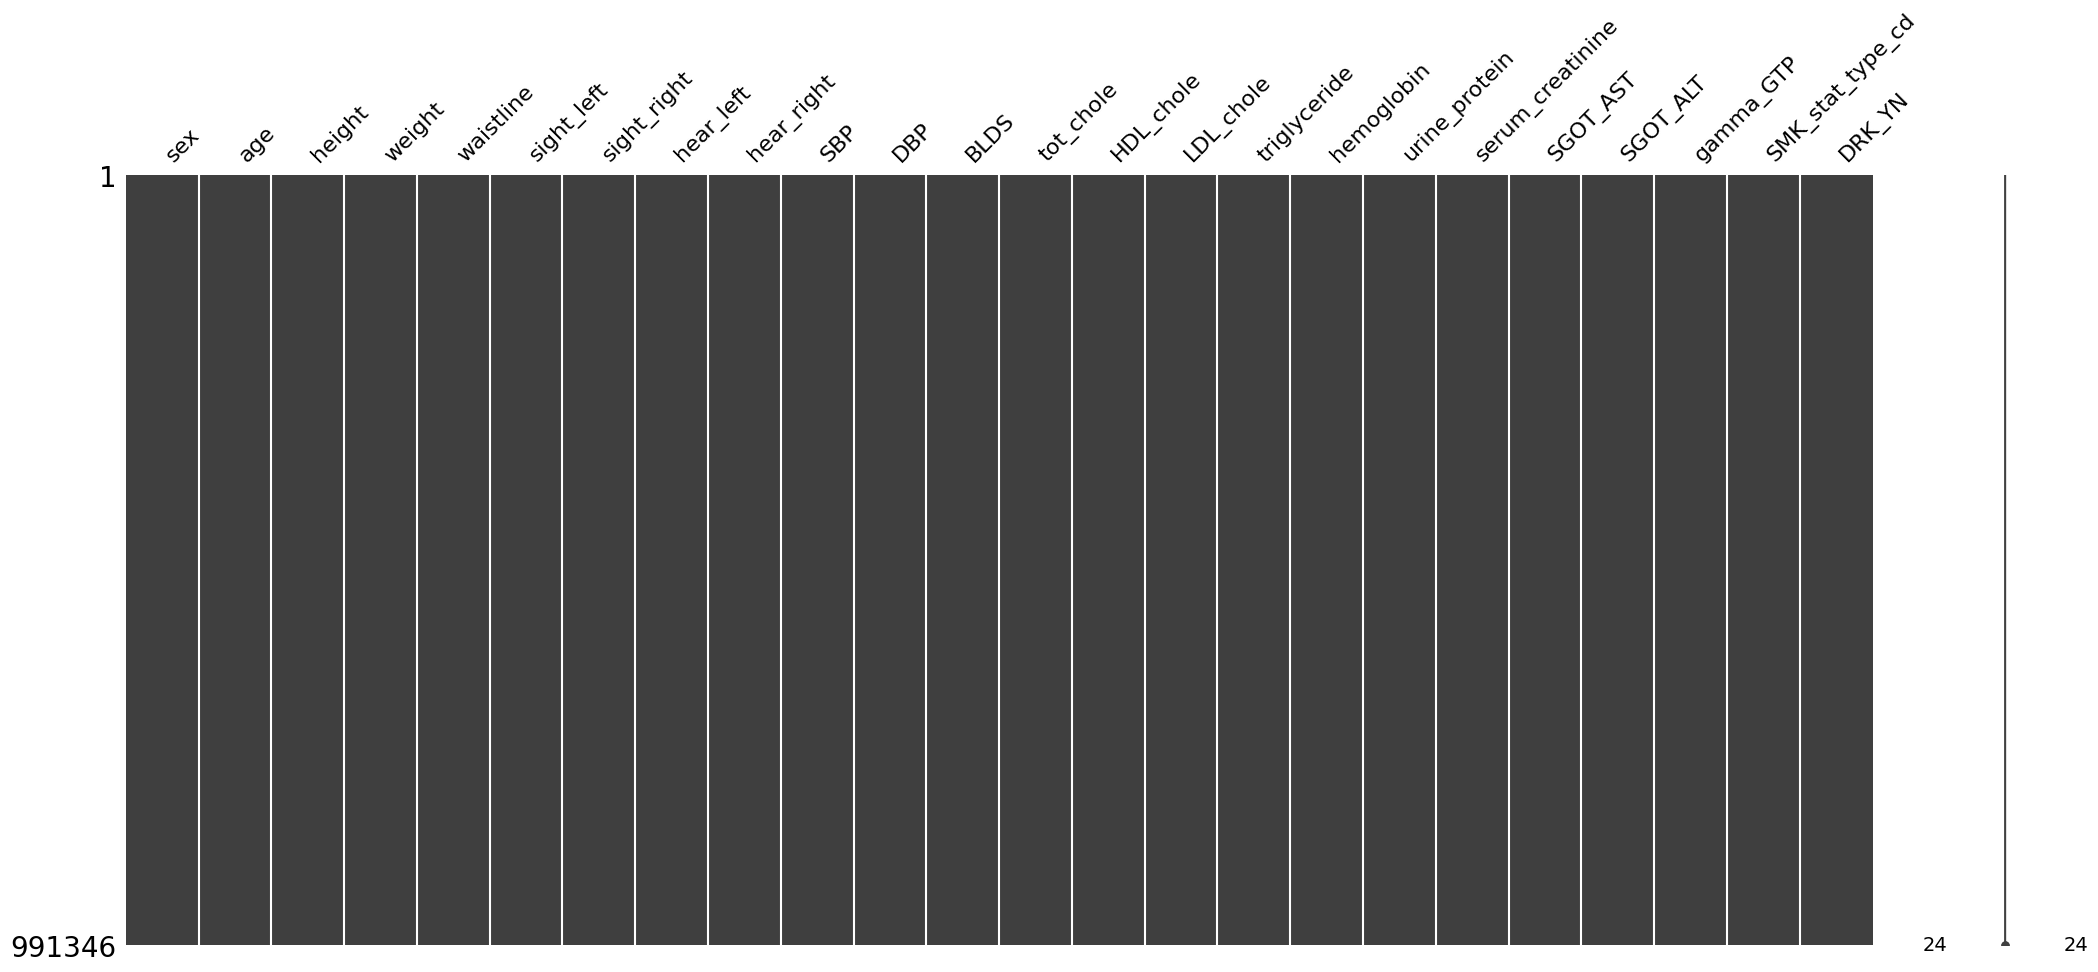

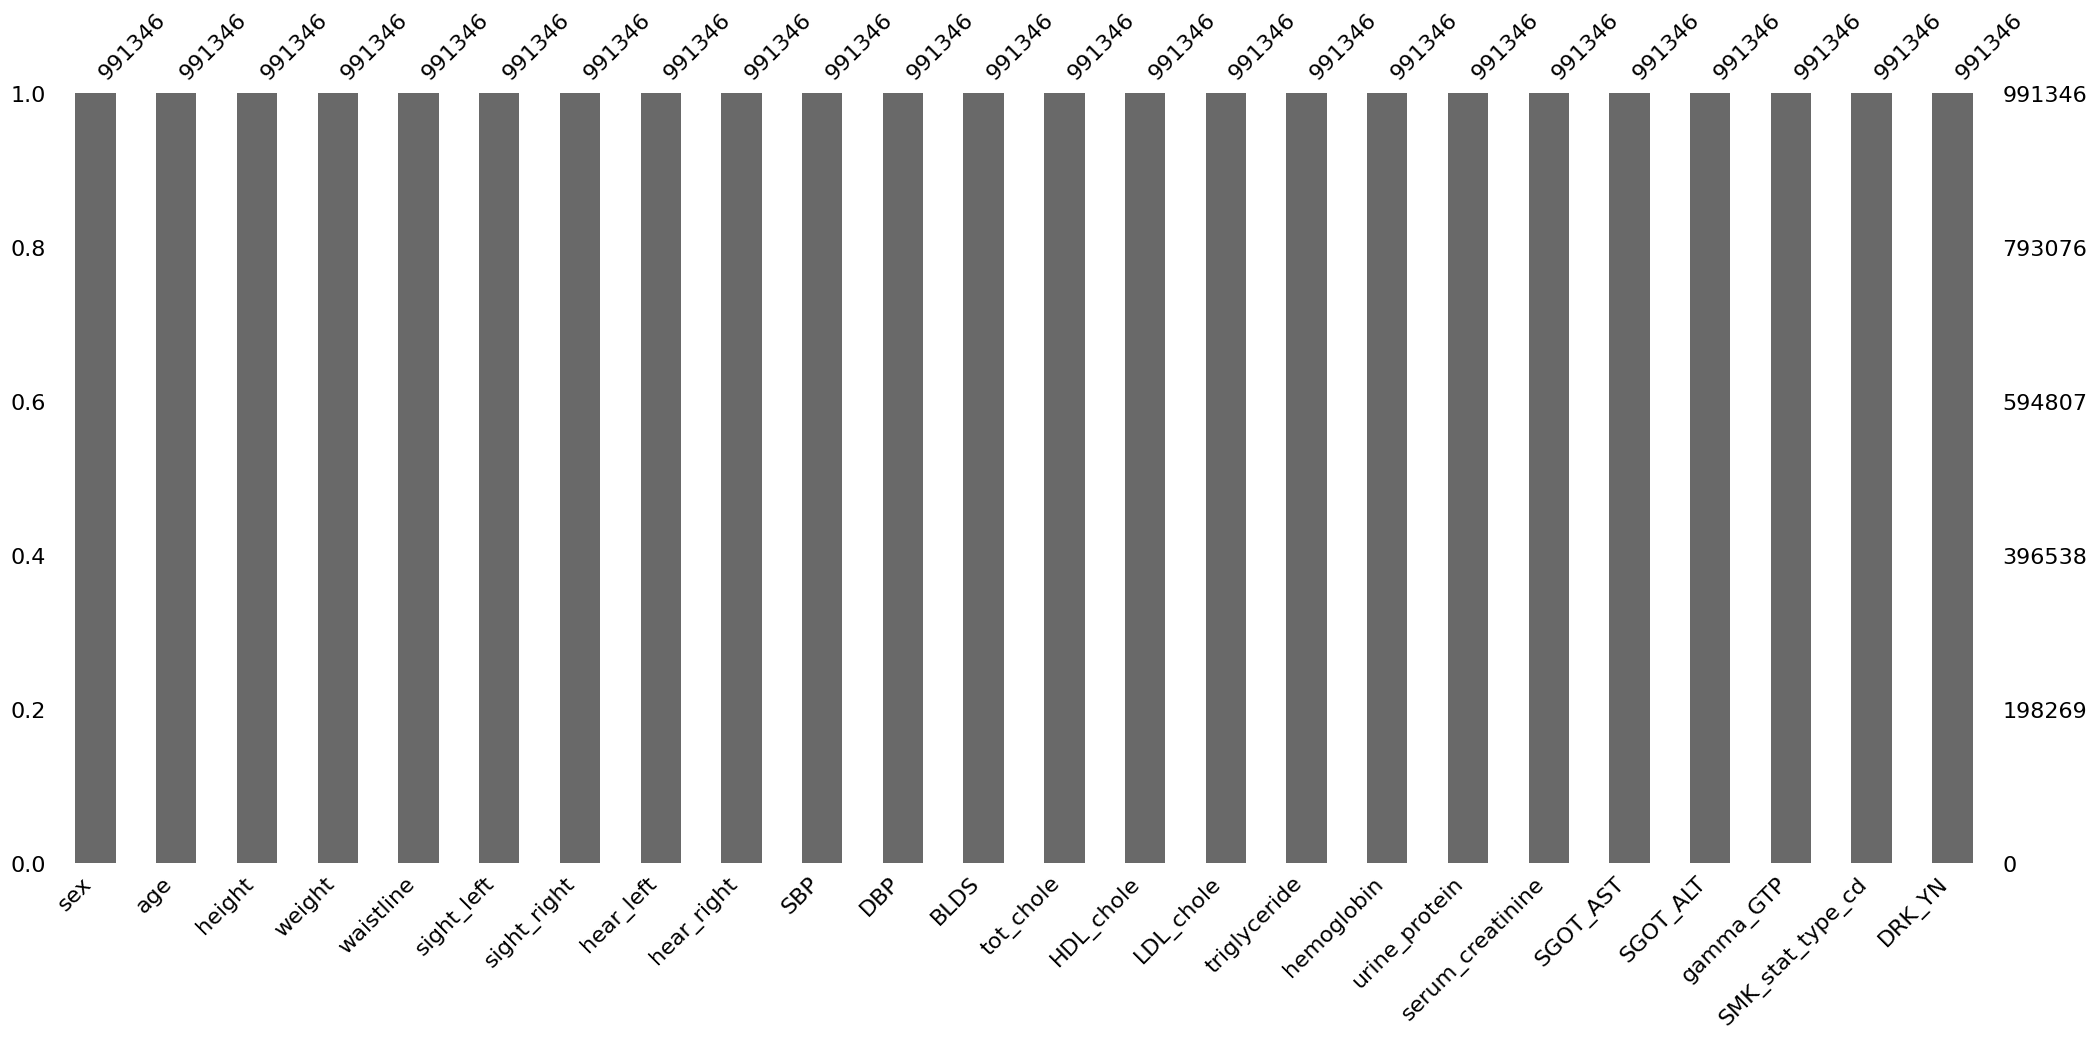


Missing Values Summary:
Series([], dtype: int64)

Missing Values Percentage:
Series([], dtype: float64)


In [9]:
# use missingno to generate missing value matrix
msno.matrix(df)
plt.show()

# use missingno to generate missing value bar chart
msno.bar(df)
plt.show()

# use pandas built-in method to view missing values
print("\nMissing Values Summary:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print("\nMissing Values Percentage:")
print((df.isnull().sum() / len(df) * 100)[df.isnull().sum() > 0].round(2))

### 2.4 Data distribution visualization

In [10]:
def plot_numerical_distributions(df, columns, n_cols=3):
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        sns.histplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(f'{col} Distribution')
    
    plt.tight_layout()
    plt.show()


numeric columns:


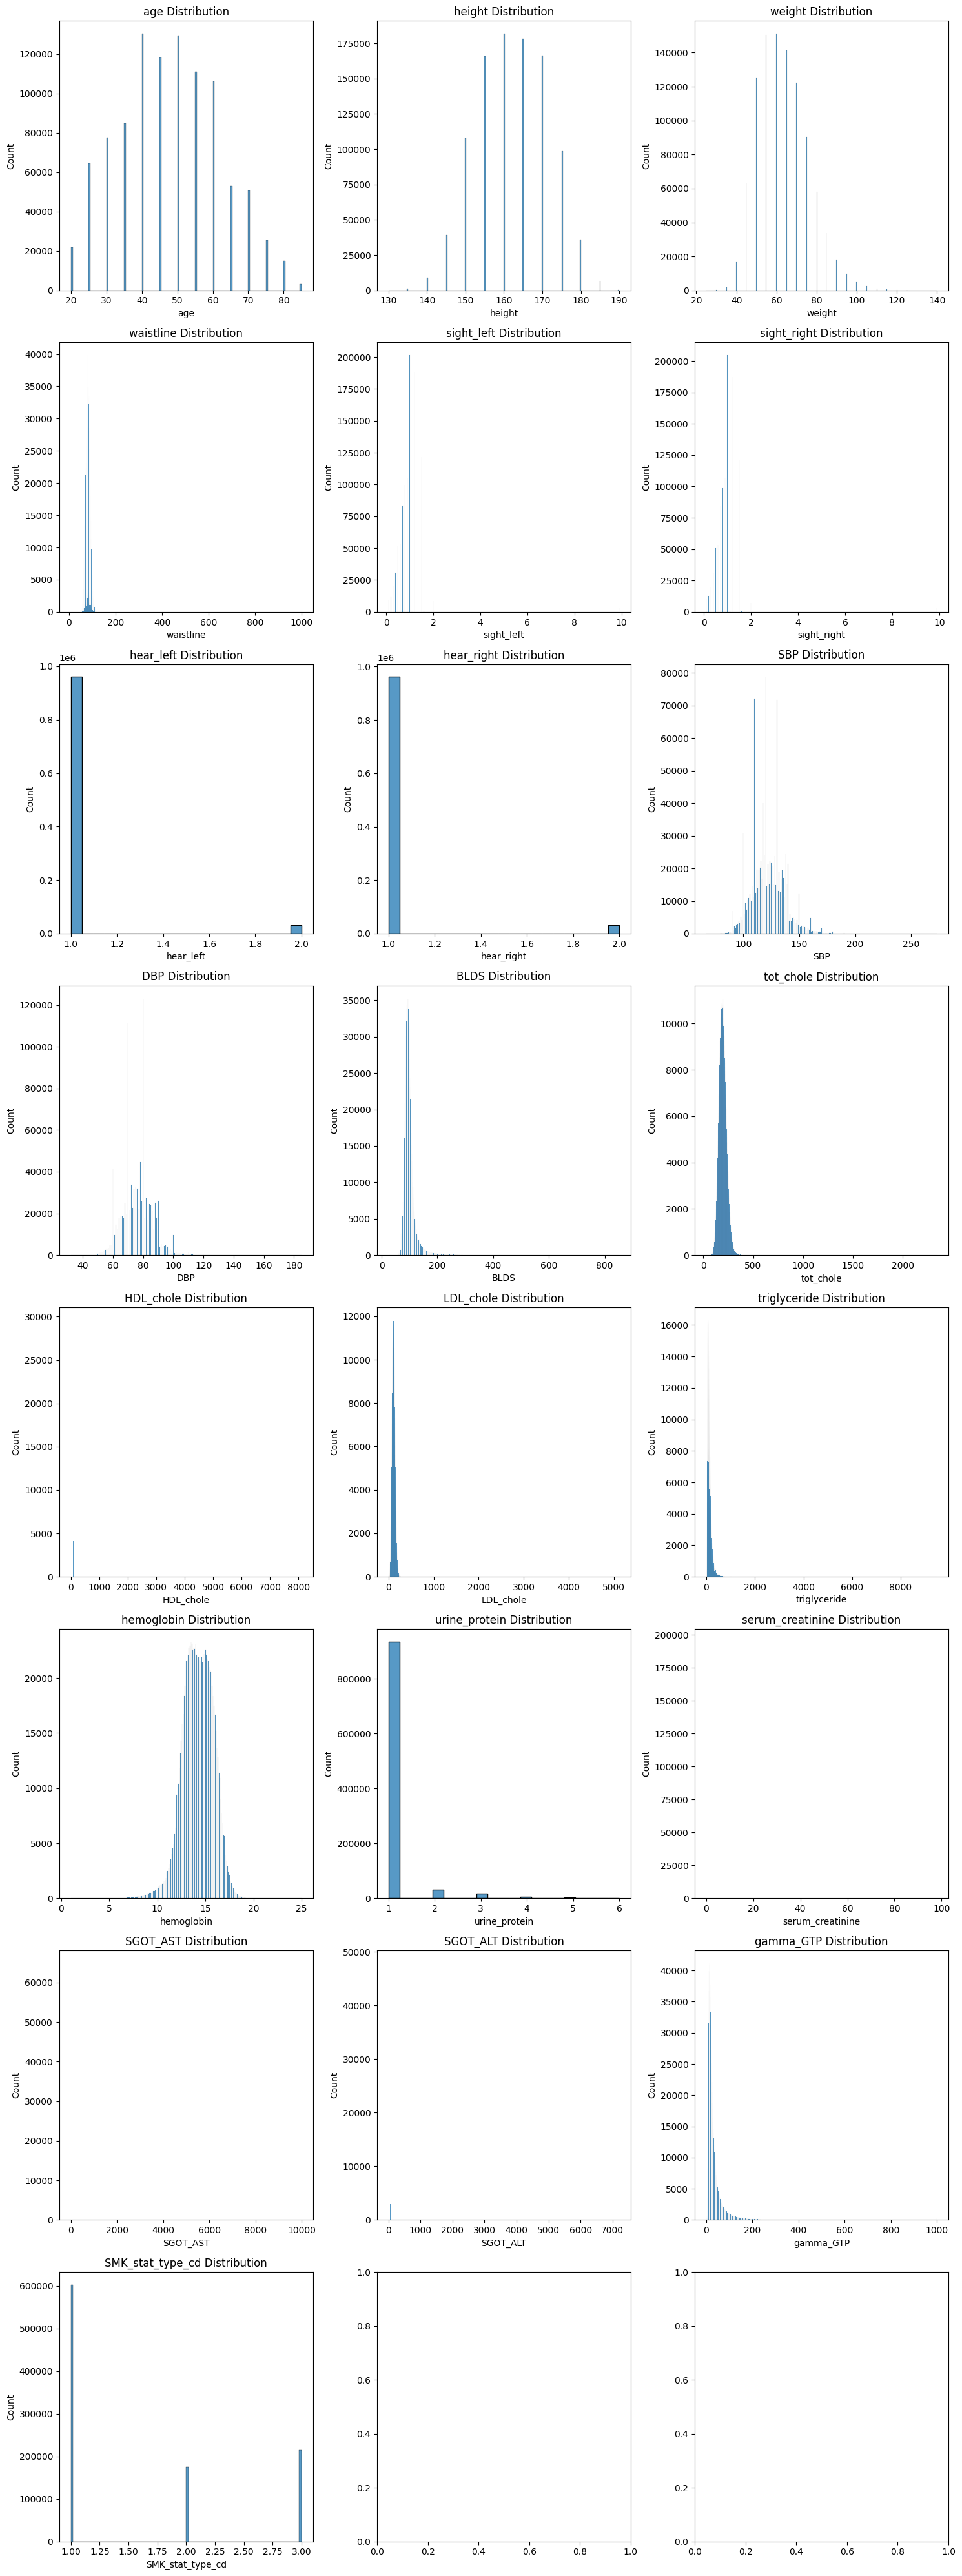

In [11]:
# select numeric columns for distribution analysis
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
print("\nnumeric columns:")
plot_numerical_distributions(df, numeric_columns)

### 2.5 Correlation Analysis

In [77]:
def plot_correlation_matrix(df):
    """
    Plot a correlation heatmap only for numeric features,
    with automatic adjustment based on feature count.

    Parameters:
    - df: pandas DataFrame
    """
    # Keep only numeric columns
    numeric_df = df.select_dtypes(include=['float64', 'int64'])

    # Calculate correlation matrix
    corr = numeric_df.corr()

    # Mask upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    n_features = corr.shape[0]

    # Auto settings
    if n_features <= 20:
        figsize = (10, 8)
        annot = True
        fontsize = 10
    elif n_features <= 50:
        figsize = (14, 10)
        annot = True
        fontsize = 7
    else:
        figsize = (18, 14)
        annot = False
        fontsize = 6

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        mask=mask,
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        center=0,
        annot=annot,
        fmt=".2f",
        annot_kws={"size": fontsize},
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )

    plt.title('Correlation Matrix (Numeric Features Only)', fontsize=16)
    plt.tight_layout()
    plt.show()


correlation analysis:


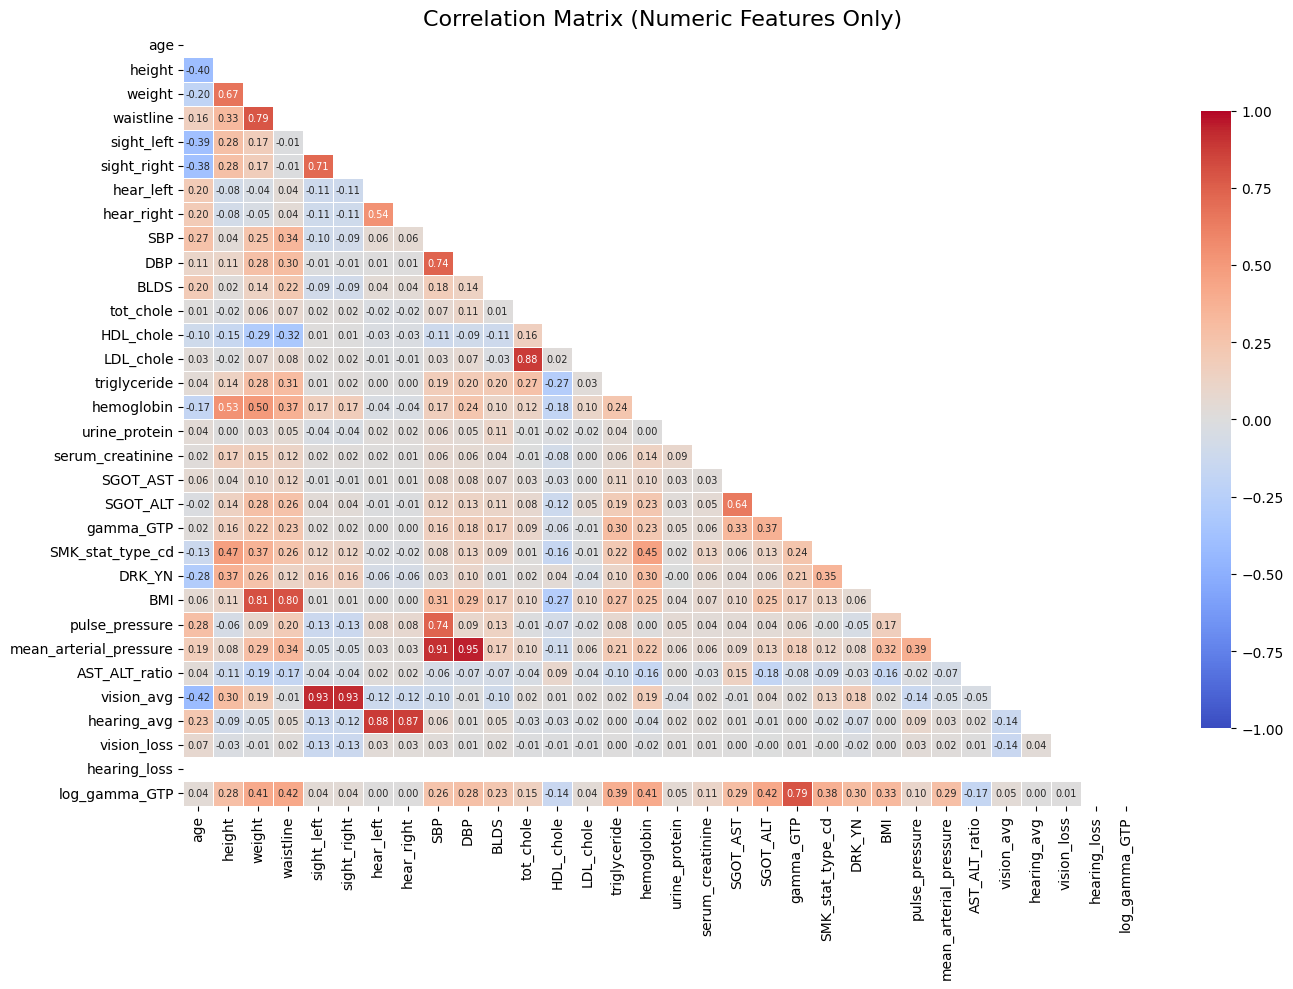

In [78]:
print("\ncorrelation analysis:")
plot_correlation_matrix(df)

### 2.5 Detect Outliers

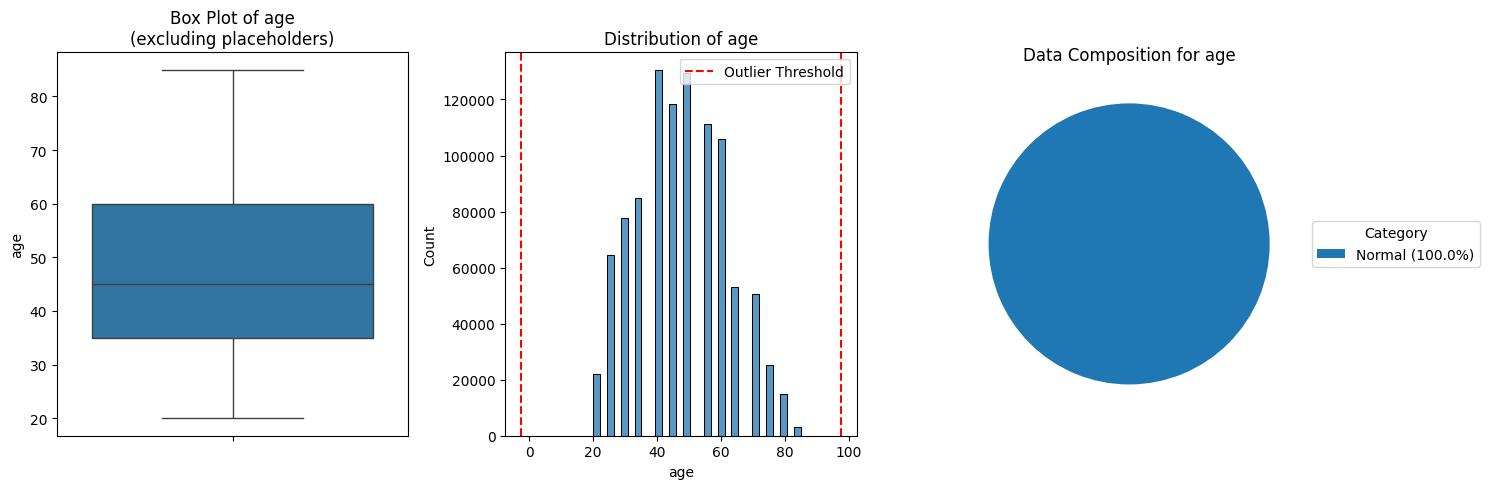


Analysis for age:
--------------------------------------------------
Total records: 991346
Normal values: 991346 (100.00%)
Outliers: 0 (0.00%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 20.00 to 85.00


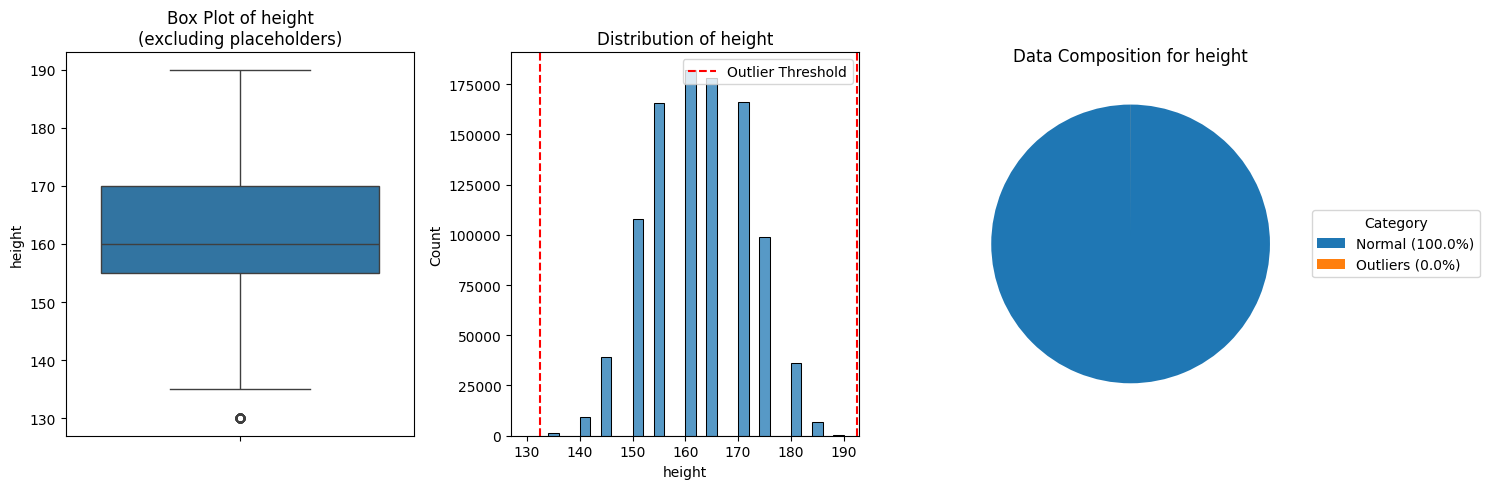


Analysis for height:
--------------------------------------------------
Total records: 991346
Normal values: 991260 (99.99%)
Outliers: 86 (0.01%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 130.00 to 190.00


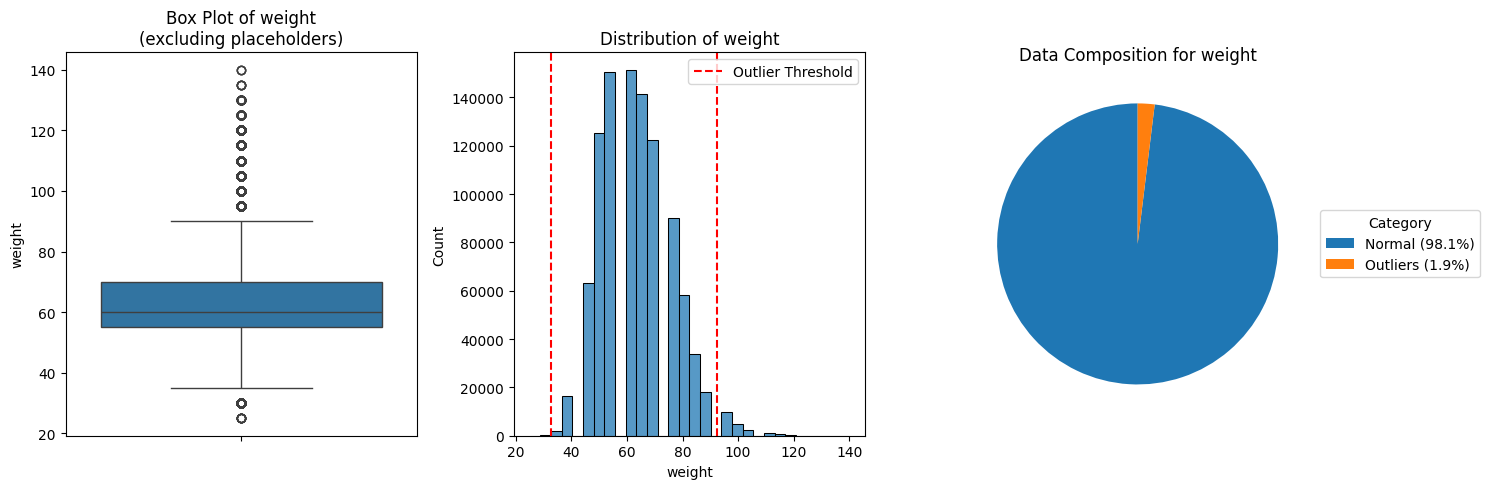


Analysis for weight:
--------------------------------------------------
Total records: 991346
Normal values: 972125 (98.06%)
Outliers: 19221 (1.94%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 25.00 to 140.00


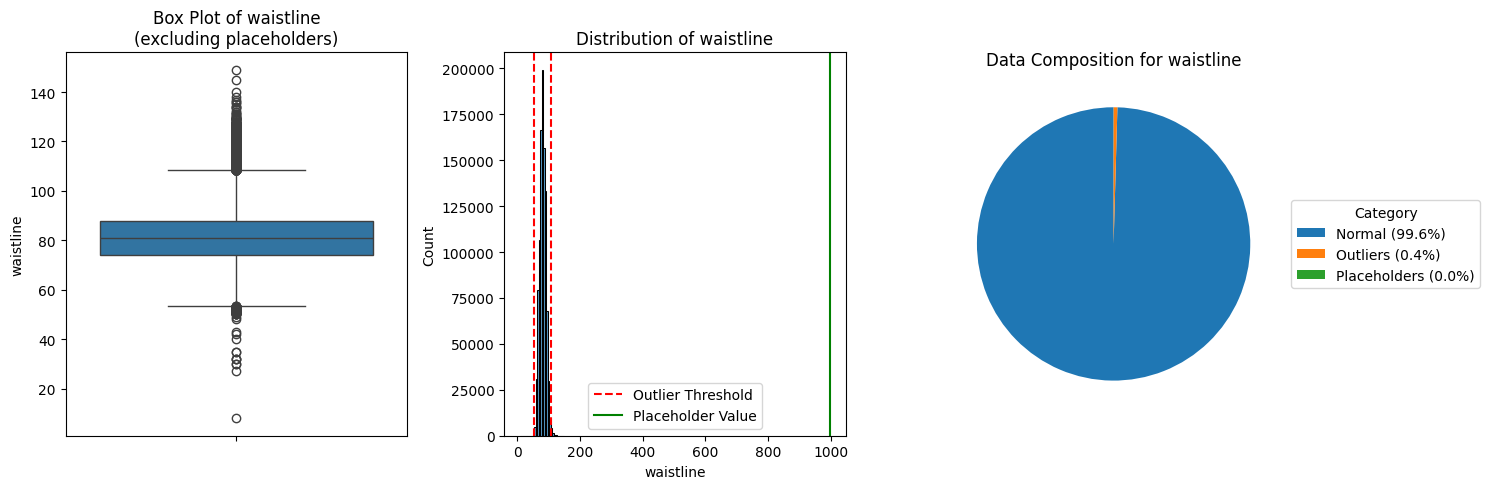


Analysis for waistline:
--------------------------------------------------
Total records: 991346
Normal values: 986929 (99.55%)
Outliers: 4360 (0.44%)
Placeholders: 57 (0.01%)
Value range (excluding outliers and placeholders): 8.00 to 149.10
Placeholder value used: 999


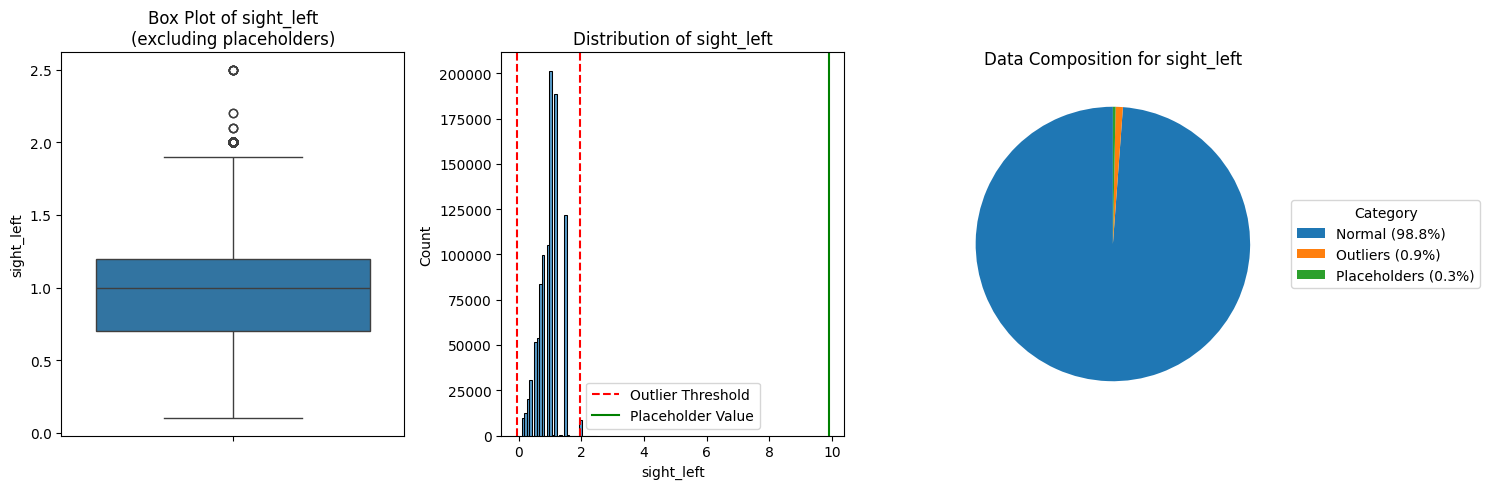


Analysis for sight_left:
--------------------------------------------------
Total records: 991346
Normal values: 979764 (98.83%)
Outliers: 8464 (0.85%)
Placeholders: 3118 (0.31%)
Value range (excluding outliers and placeholders): 0.10 to 2.50
Placeholder value used: 9.9


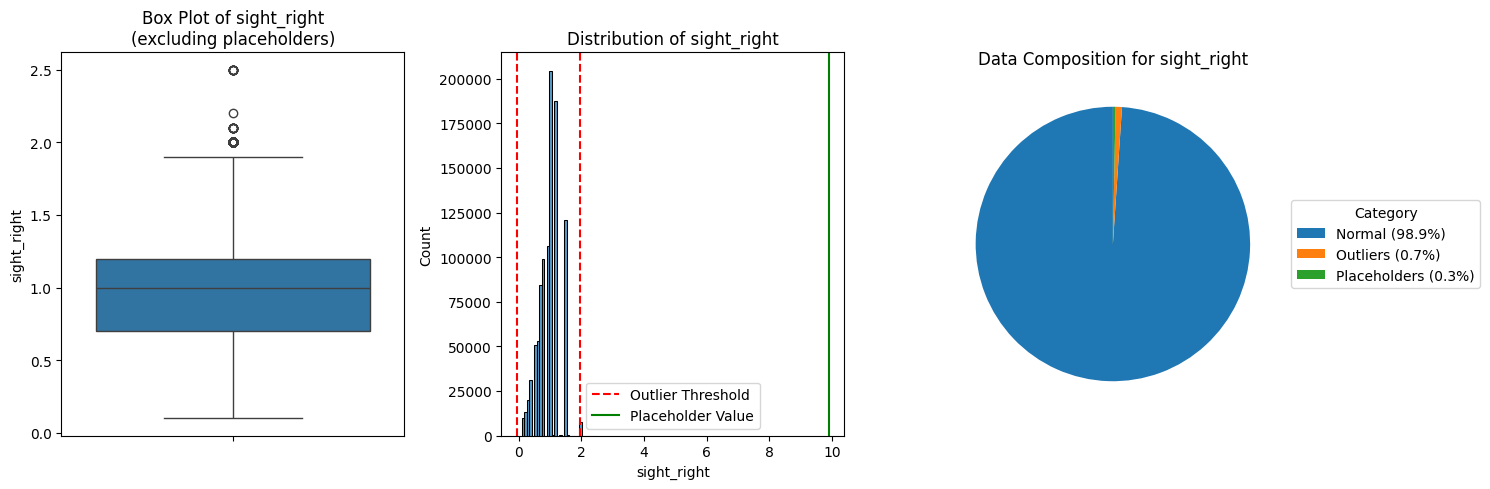


Analysis for sight_right:
--------------------------------------------------
Total records: 991346
Normal values: 980851 (98.94%)
Outliers: 7384 (0.74%)
Placeholders: 3111 (0.31%)
Value range (excluding outliers and placeholders): 0.10 to 2.50
Placeholder value used: 9.9


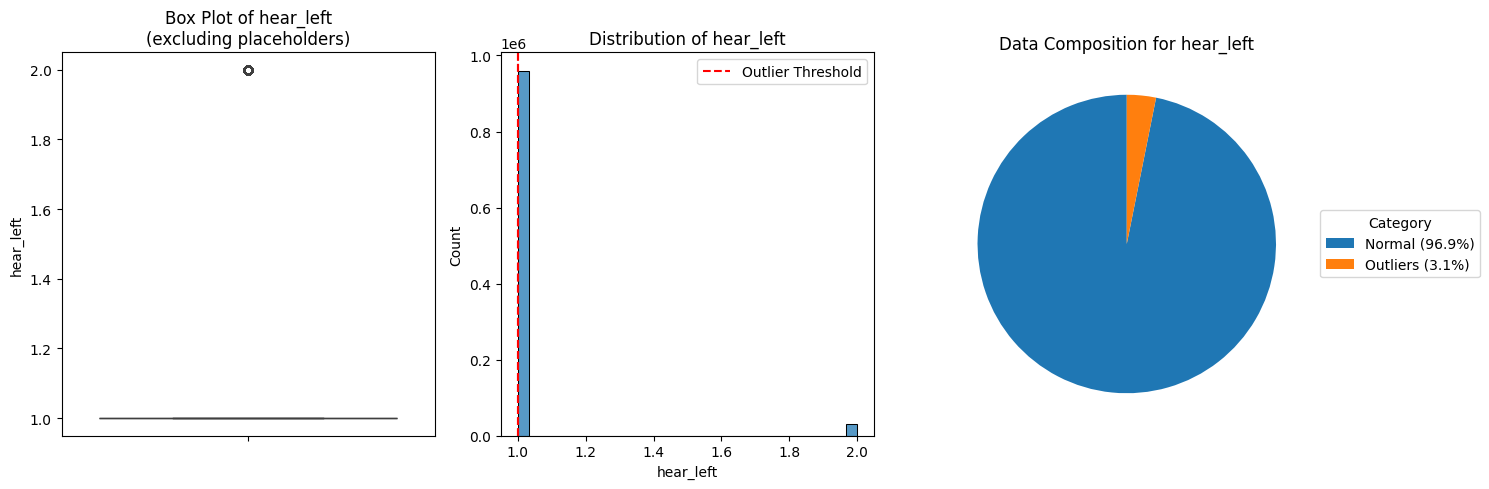


Analysis for hear_left:
--------------------------------------------------
Total records: 991346
Normal values: 960124 (96.85%)
Outliers: 31222 (3.15%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 1.00 to 2.00


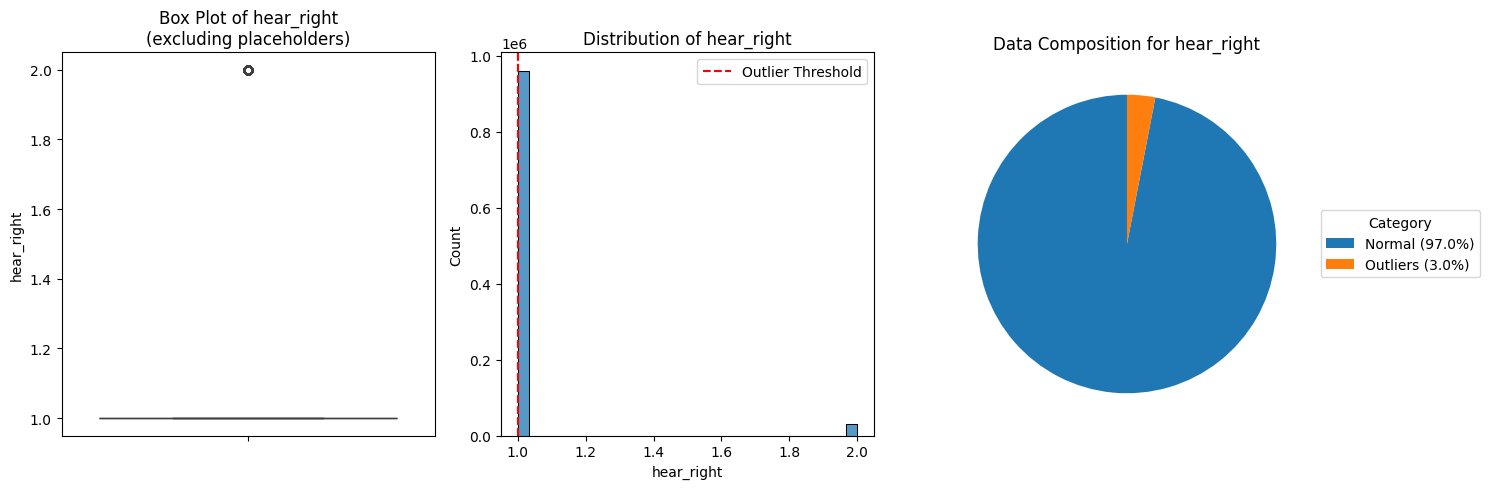


Analysis for hear_right:
--------------------------------------------------
Total records: 991346
Normal values: 961134 (96.95%)
Outliers: 30212 (3.05%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 1.00 to 2.00


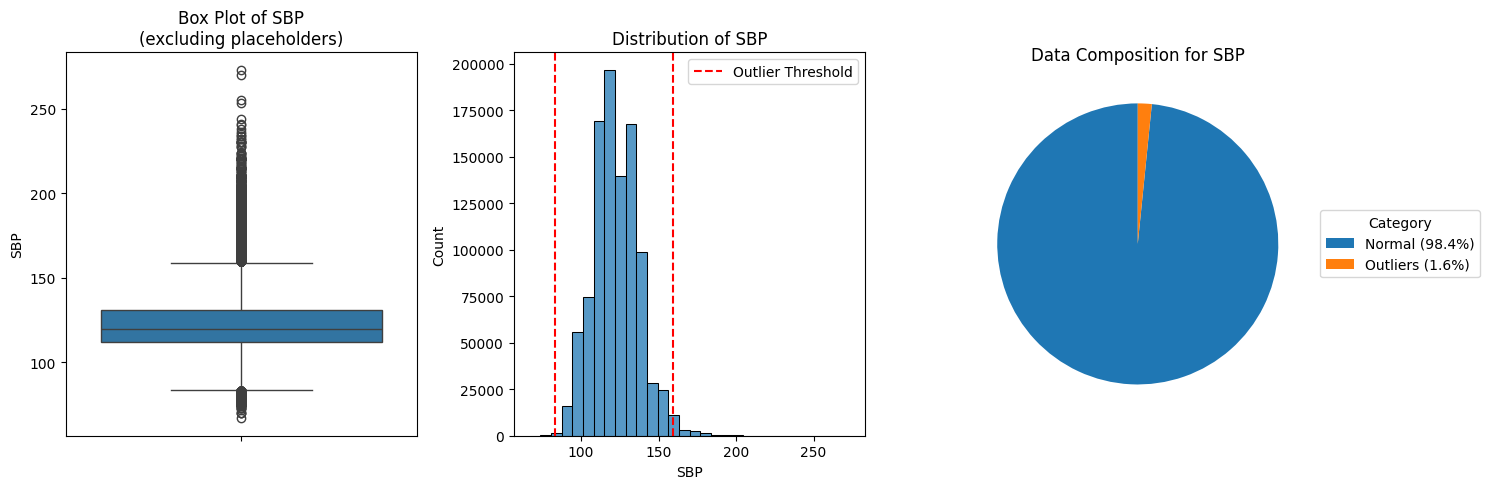


Analysis for SBP:
--------------------------------------------------
Total records: 991346
Normal values: 975510 (98.40%)
Outliers: 15836 (1.60%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 67.00 to 273.00


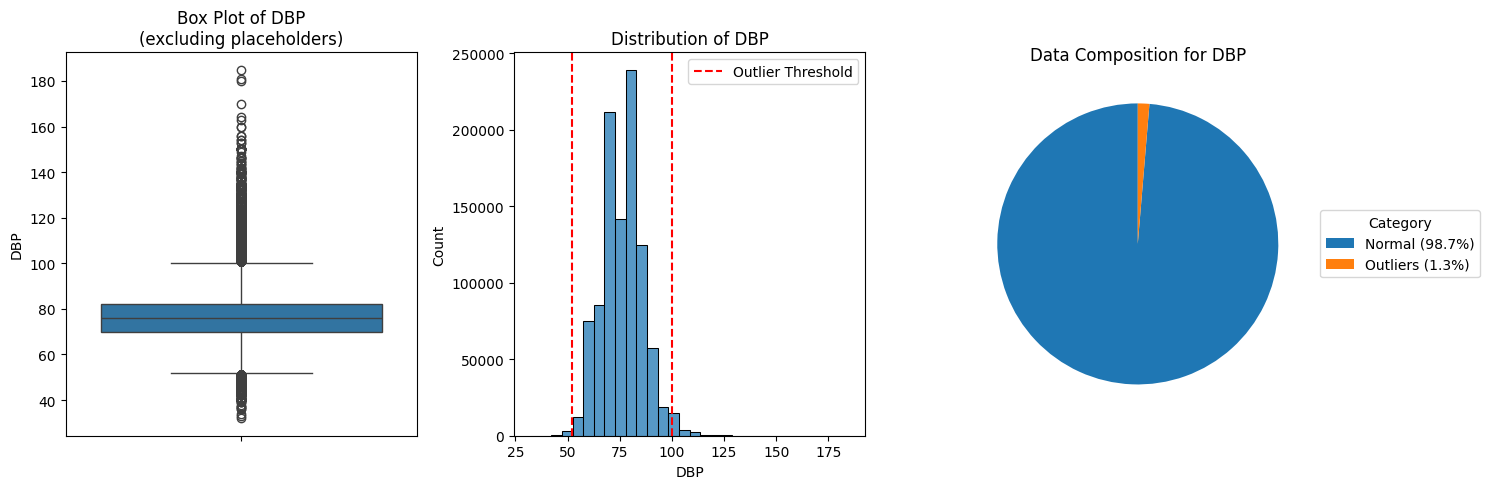


Analysis for DBP:
--------------------------------------------------
Total records: 991346
Normal values: 978224 (98.68%)
Outliers: 13122 (1.32%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 32.00 to 185.00


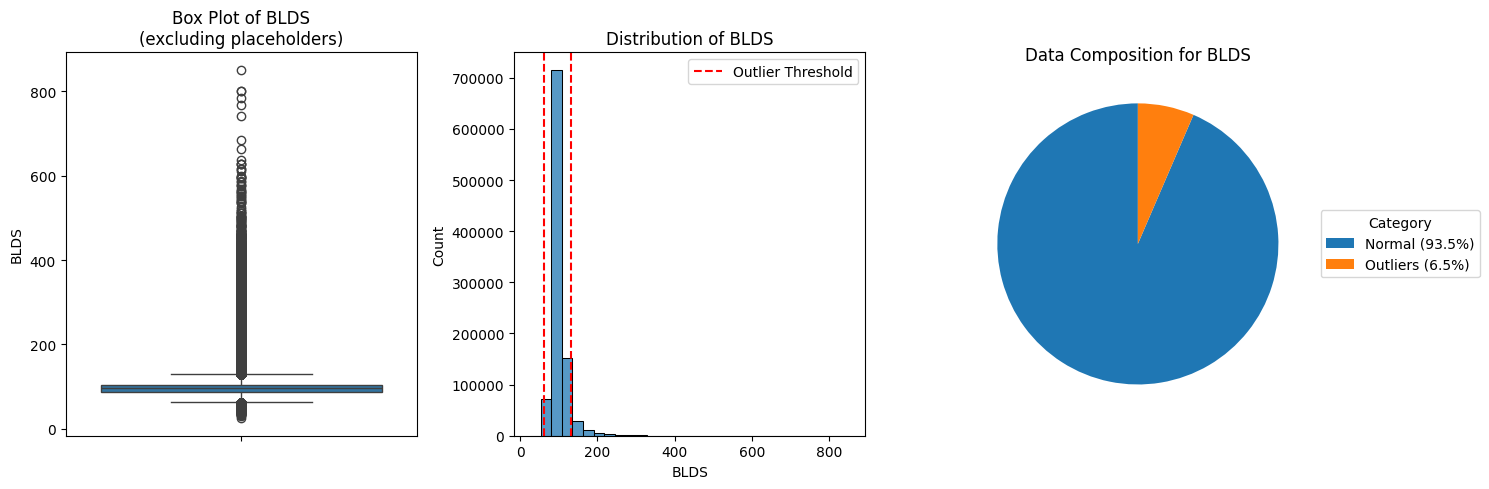


Analysis for BLDS:
--------------------------------------------------
Total records: 991346
Normal values: 927144 (93.52%)
Outliers: 64202 (6.48%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 25.00 to 852.00


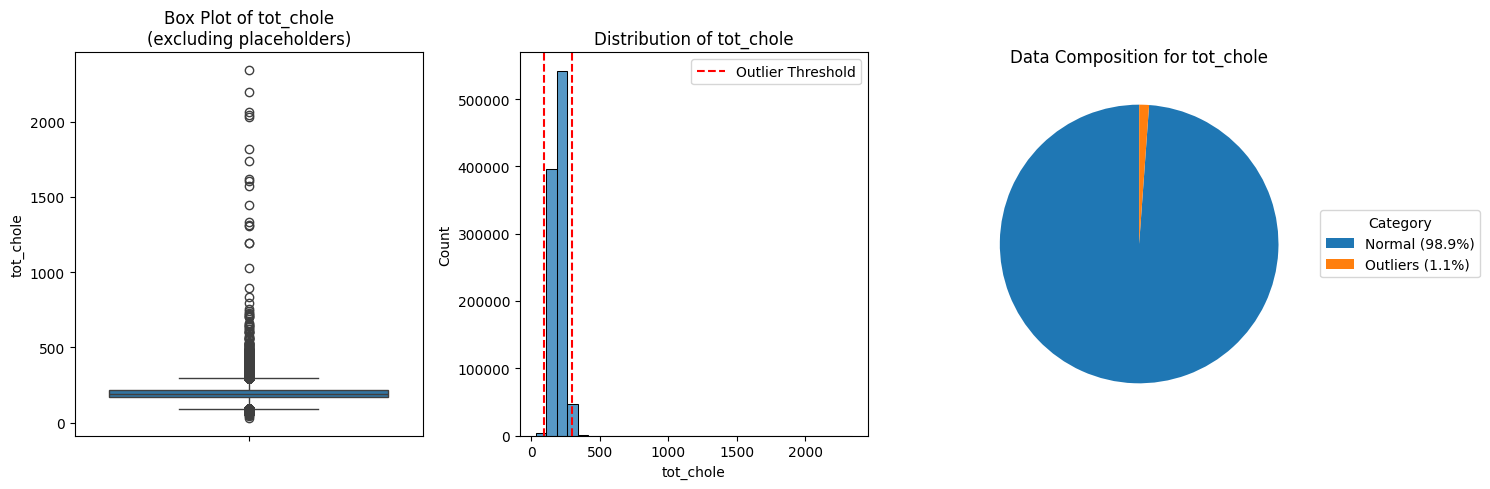


Analysis for tot_chole:
--------------------------------------------------
Total records: 991346
Normal values: 980048 (98.86%)
Outliers: 11298 (1.14%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 30.00 to 2344.00


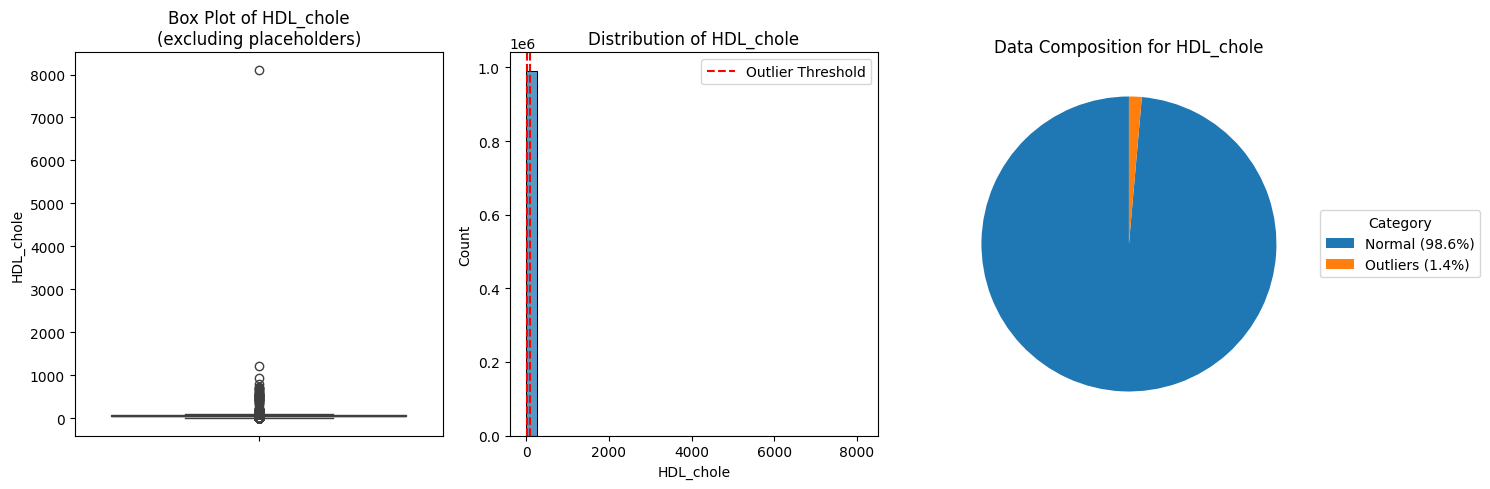


Analysis for HDL_chole:
--------------------------------------------------
Total records: 991346
Normal values: 977488 (98.60%)
Outliers: 13858 (1.40%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 1.00 to 8110.00


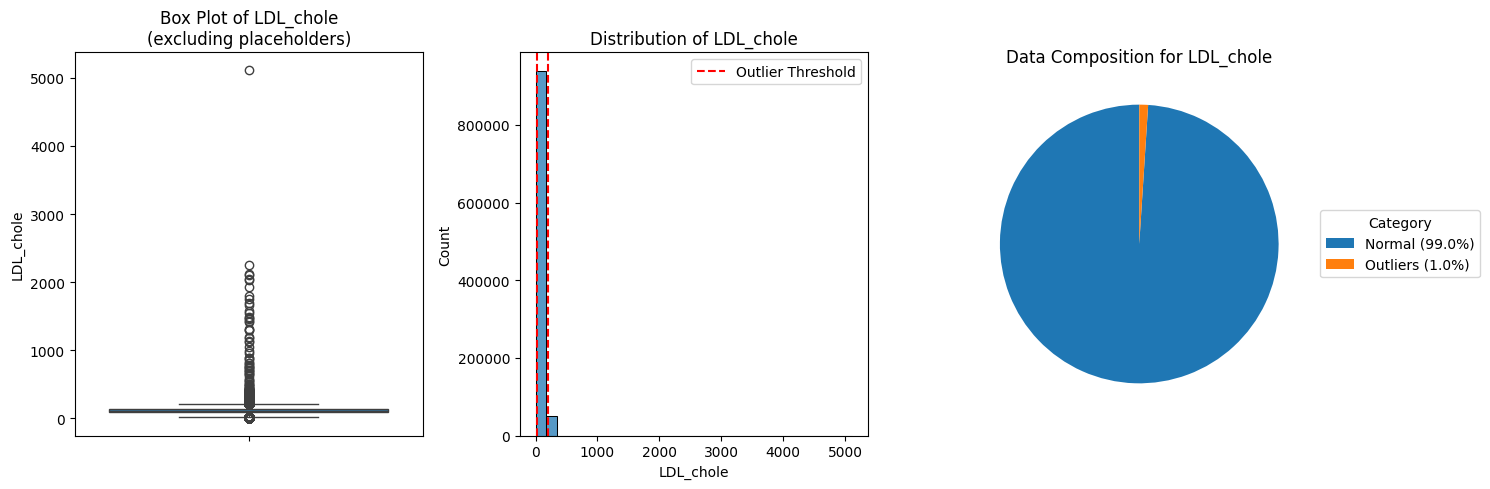


Analysis for LDL_chole:
--------------------------------------------------
Total records: 991346
Normal values: 981248 (98.98%)
Outliers: 10098 (1.02%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 1.00 to 5119.00


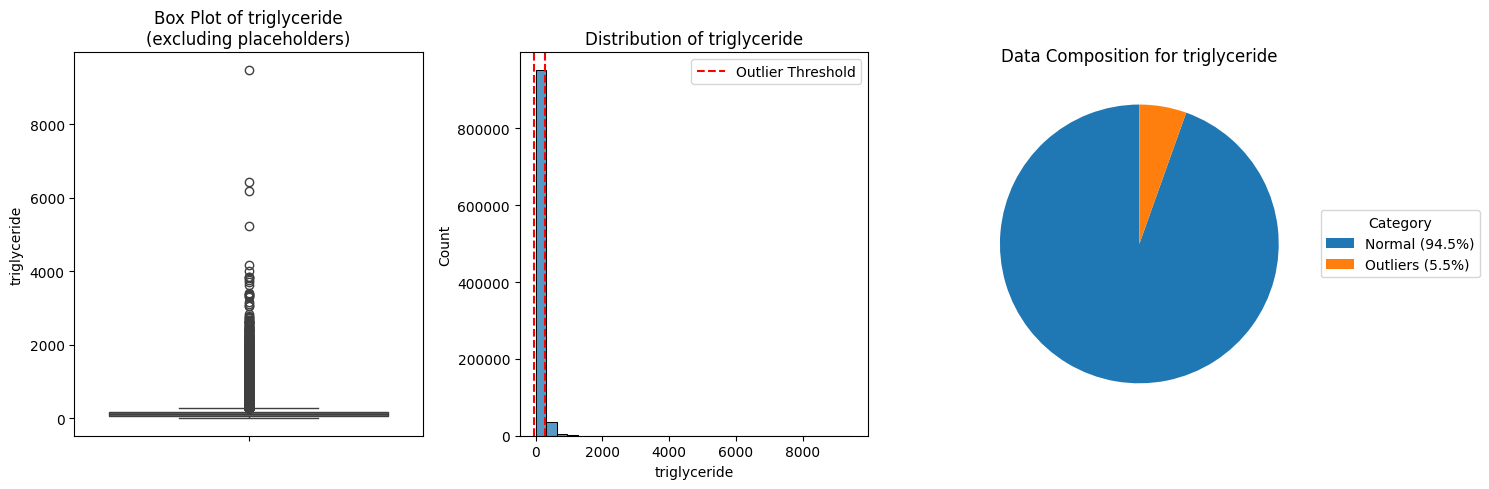


Analysis for triglyceride:
--------------------------------------------------
Total records: 991346
Normal values: 937242 (94.54%)
Outliers: 54104 (5.46%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 1.00 to 9490.00


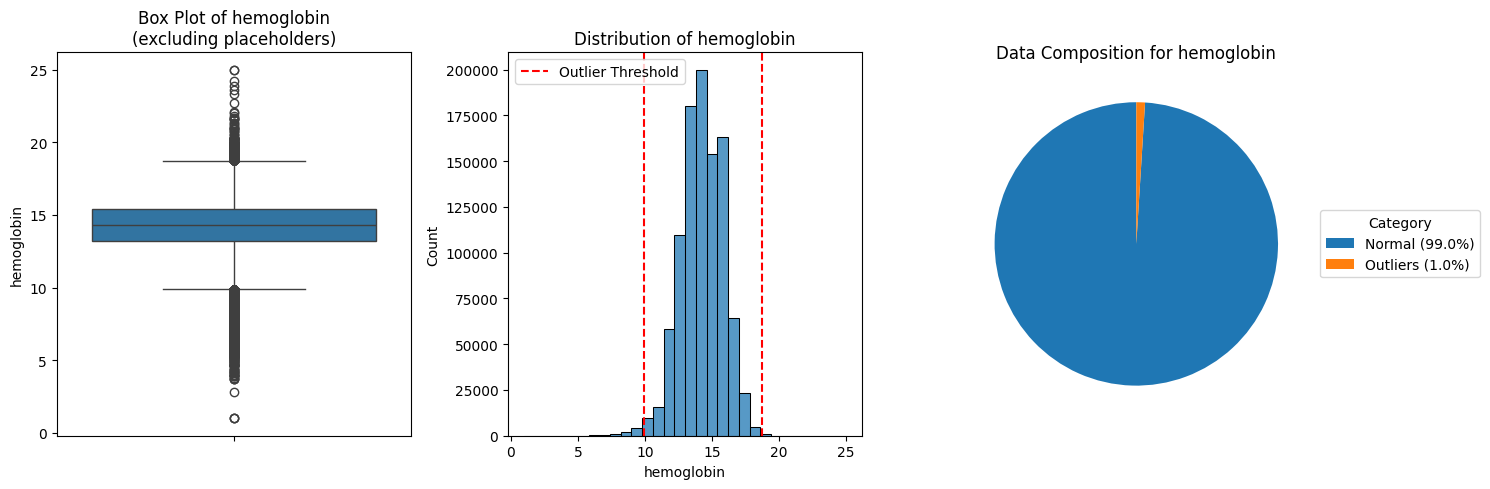


Analysis for hemoglobin:
--------------------------------------------------
Total records: 991346
Normal values: 981586 (99.02%)
Outliers: 9760 (0.98%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 1.00 to 25.00


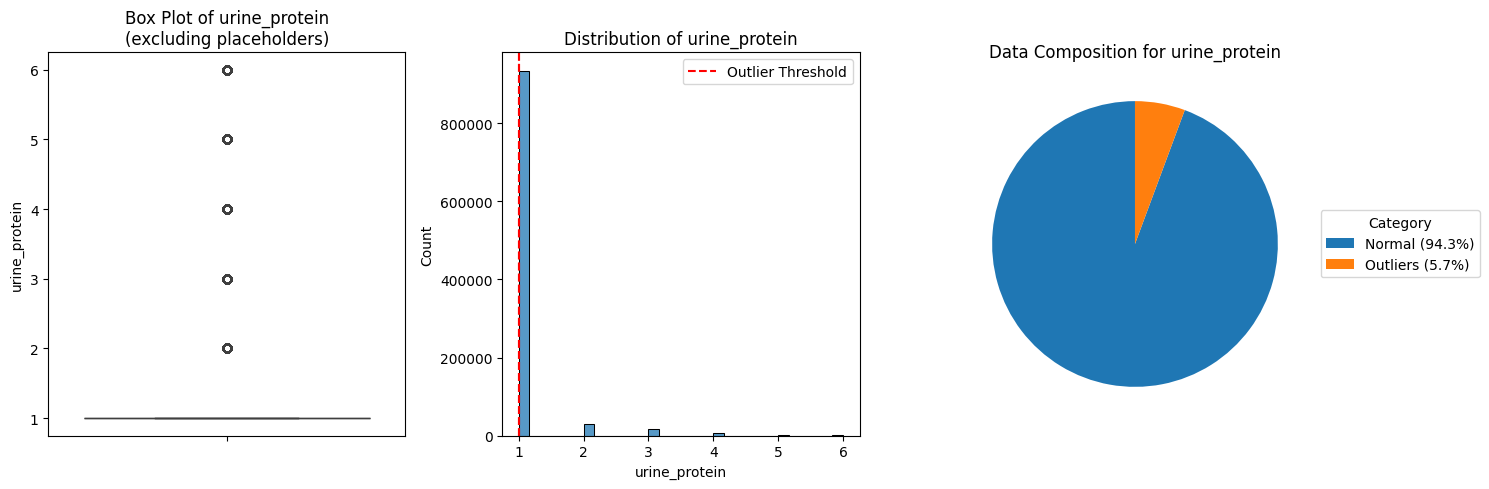


Analysis for urine_protein:
--------------------------------------------------
Total records: 991346
Normal values: 935175 (94.33%)
Outliers: 56171 (5.67%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 1.00 to 6.00


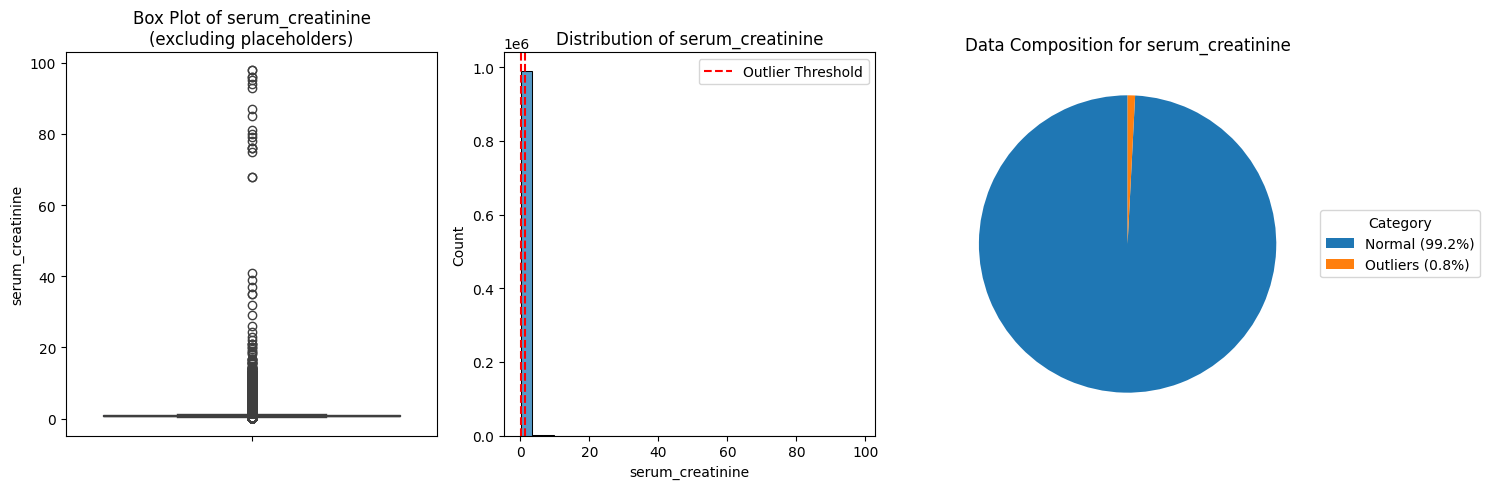


Analysis for serum_creatinine:
--------------------------------------------------
Total records: 991346
Normal values: 983341 (99.19%)
Outliers: 8005 (0.81%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 0.10 to 98.00


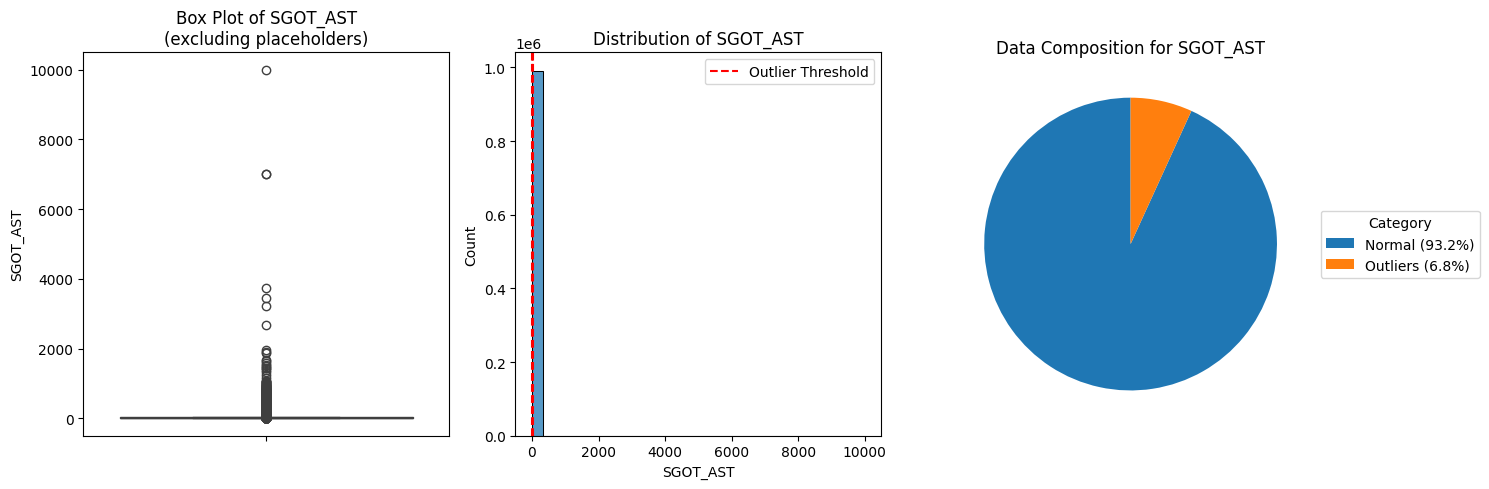


Analysis for SGOT_AST:
--------------------------------------------------
Total records: 991346
Normal values: 923732 (93.18%)
Outliers: 67614 (6.82%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 1.00 to 9999.00


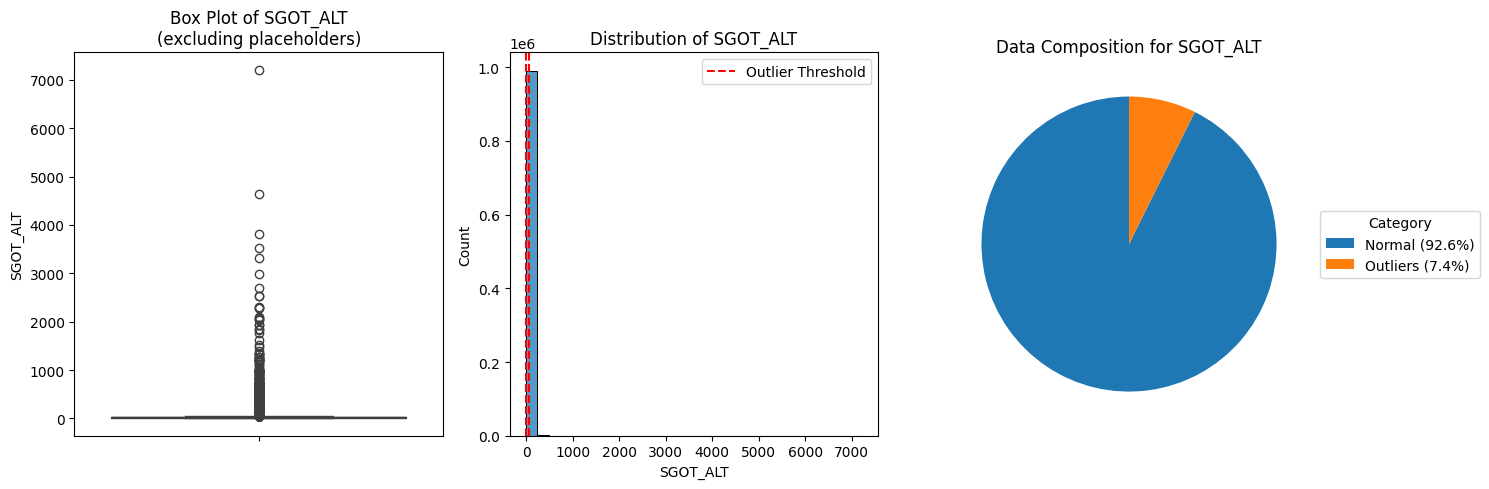


Analysis for SGOT_ALT:
--------------------------------------------------
Total records: 991346
Normal values: 918418 (92.64%)
Outliers: 72928 (7.36%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 1.00 to 7210.00


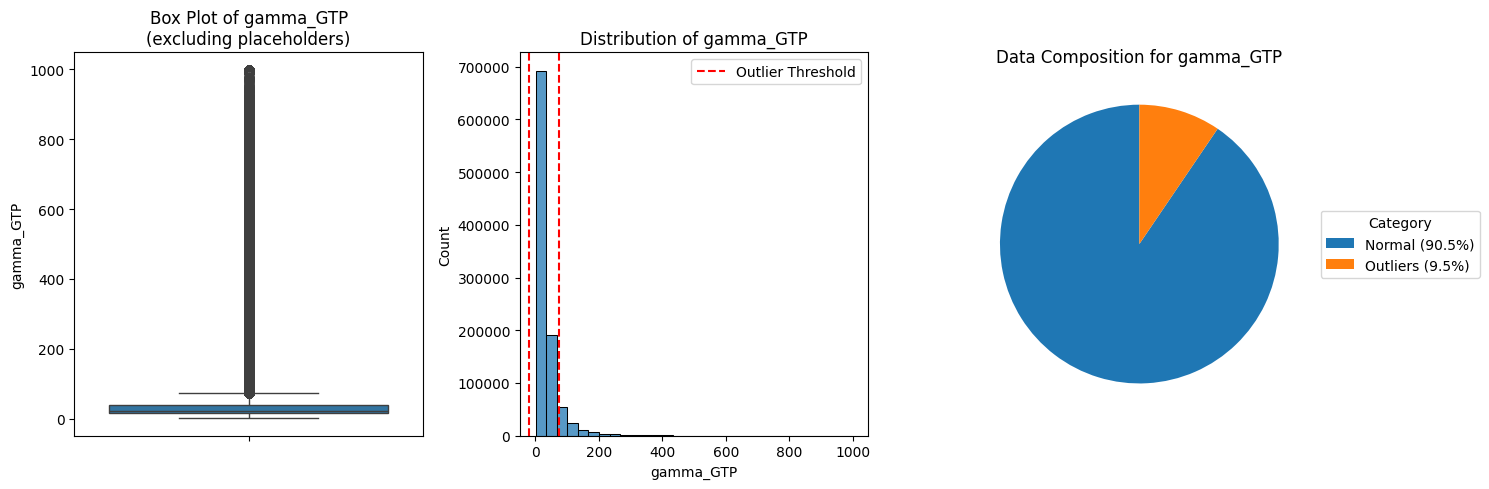


Analysis for gamma_GTP:
--------------------------------------------------
Total records: 991346
Normal values: 897204 (90.50%)
Outliers: 94142 (9.50%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 1.00 to 999.00


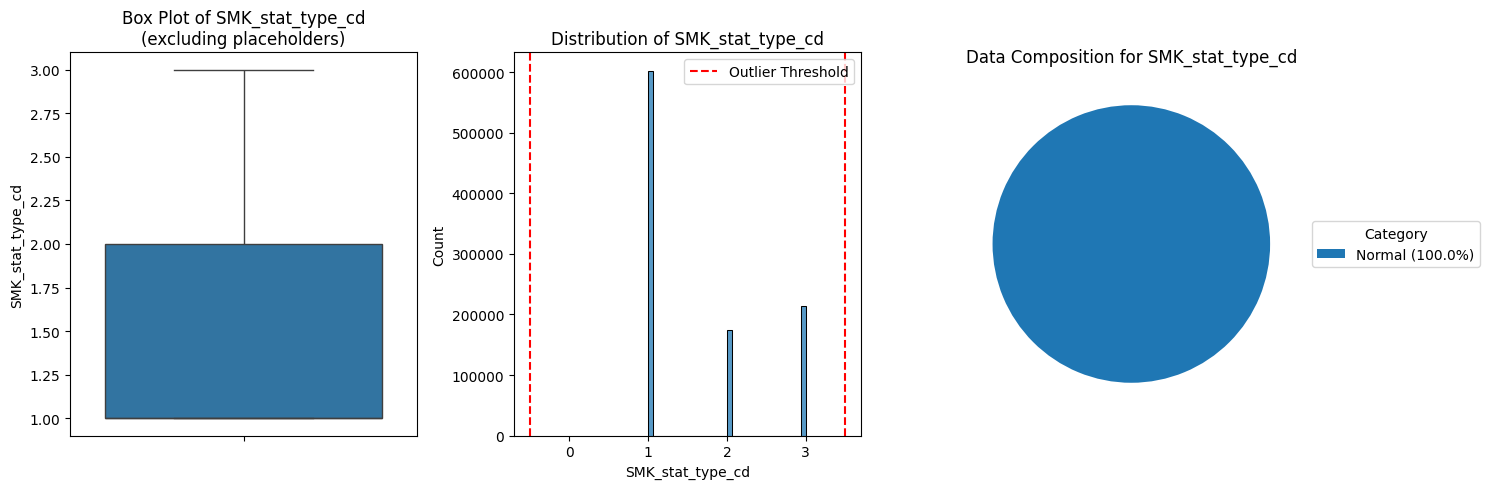


Analysis for SMK_stat_type_cd:
--------------------------------------------------
Total records: 991346
Normal values: 991346 (100.00%)
Outliers: 0 (0.00%)
Placeholders: 0 (0.00%)
Value range (excluding outliers and placeholders): 1.00 to 3.00


In [19]:
def detect_outliers_and_placeholders(df, columns):
    """
    Detect both outliers and placeholder values in the dataset
    """
    results = {}  # Dictionary to store results for each column
    
    # Define known placeholder values
    placeholders = {
        'waistline': 999,
        'sight_left': 9.9,
        'sight_right': 9.9,
        # 'column_name': placeholder_value,
    }
    
    for col in columns:
        # Only proceed if the column is of numeric type
        if df[col].dtype in ['int64', 'float64']:
            # Initialize results dictionary for this column
            results[col] = {
                'outliers': 0,
                'placeholders': 0,
                'outlier_percentage': 0,
                'placeholder_percentage': 0
            }
            
            # Check for placeholder values first
            if col in placeholders:
                placeholder_mask = df[col] == placeholders[col]
                placeholder_count = placeholder_mask.sum()
                
                # Remove placeholder values for outlier detection
                df_clean = df[~placeholder_mask]
            else:
                placeholder_count = 0
                df_clean = df
            
            # Calculate quartiles excluding placeholder values
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # Define bounds for outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Count outliers (excluding placeholder values)
            outlier_count = df_clean[(df_clean[col] < lower_bound) | 
                                   (df_clean[col] > upper_bound)][col].count()
            
            # Store results
            total_rows = len(df)
            results[col]['outliers'] = outlier_count
            results[col]['placeholders'] = placeholder_count
            results[col]['outlier_percentage'] = (outlier_count / total_rows) * 100
            results[col]['placeholder_percentage'] = (placeholder_count / total_rows) * 100
            
            # Visualization for this column
            plt.figure(figsize=(15, 5))
            
            # Plot 1: Box Plot (excluding placeholders)
            plt.subplot(131)
            sns.boxplot(y=df_clean[col])
            plt.title(f'Box Plot of {col}\n(excluding placeholders)')
            
            # Plot 2: Distribution
            plt.subplot(132)
            sns.histplot(data=df_clean, x=col, bins=30)
            plt.axvline(x=lower_bound, color='r', linestyle='--', label='Outlier Threshold')
            plt.axvline(x=upper_bound, color='r', linestyle='--')
            if col in placeholders:
                plt.axvline(x=placeholders[col], color='g', linestyle='-', 
                          label='Placeholder Value')
            plt.title(f'Distribution of {col}')
            plt.legend()
            
            # Plot 3: Improved Pie Chart for Small Values
            
            plt.subplot(133)
            normal_count = total_rows - outlier_count - placeholder_count
            sizes = [normal_count, outlier_count, placeholder_count]
            labels = ['Normal', 'Outliers', 'Placeholders']

            # Filter out zero-size categories
            sizes_nonzero = [size for size in sizes if size > 0]
            labels_nonzero = [label for size, label in zip(sizes, labels) if size > 0]

            # Compute percentages manually
            total = sum(sizes_nonzero)
            percentages = [size / total * 100 for size in sizes_nonzero]

            # Build legend labels with percentages
            legend_labels = [f"{label} ({pct:.1f}%)" for label, pct in zip(labels_nonzero, percentages)]

            # Handle case when everything is zero
            if len(sizes_nonzero) == 0:
                sizes_nonzero = [1]
                legend_labels = ['No Data']

            # Plot pie chart without labels or percentages
            wedges, _ = plt.pie(
                sizes_nonzero,
                startangle=90,
                labels=None,          # No label inside pie
                autopct=None,          # No percentage inside pie
                textprops={'fontsize': 10}
            )

            # Add a clean legend with category names and percentages
            plt.legend(
                wedges, legend_labels,
                title="Category",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1),
                fontsize=10
            )

            plt.title(f'Data Composition for {col}')
            plt.tight_layout()
            plt.show()
            
            # Print detailed statistics
            print(f"\nAnalysis for {col}:")
            print("-" * 50)
            print(f"Total records: {total_rows}")
            print(f"Normal values: {normal_count} ({normal_count/total_rows*100:.2f}%)")
            print(f"Outliers: {outlier_count} ({results[col]['outlier_percentage']:.2f}%)")
            print(f"Placeholders: {placeholder_count} ({results[col]['placeholder_percentage']:.2f}%)")
            print(f"Value range (excluding outliers and placeholders): {df_clean[col].min():.2f} to {df_clean[col].max():.2f}")
            
            if col in placeholders:
                print(f"Placeholder value used: {placeholders[col]}")
    
    return results

# 使用函数
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
results = detect_outliers_and_placeholders(df, numeric_columns)


### 2.6 Categorical Variable Analysis


categorical variable analysis:

sex distribution:
sex
Male      526415
Female    464931
Name: count, dtype: int64


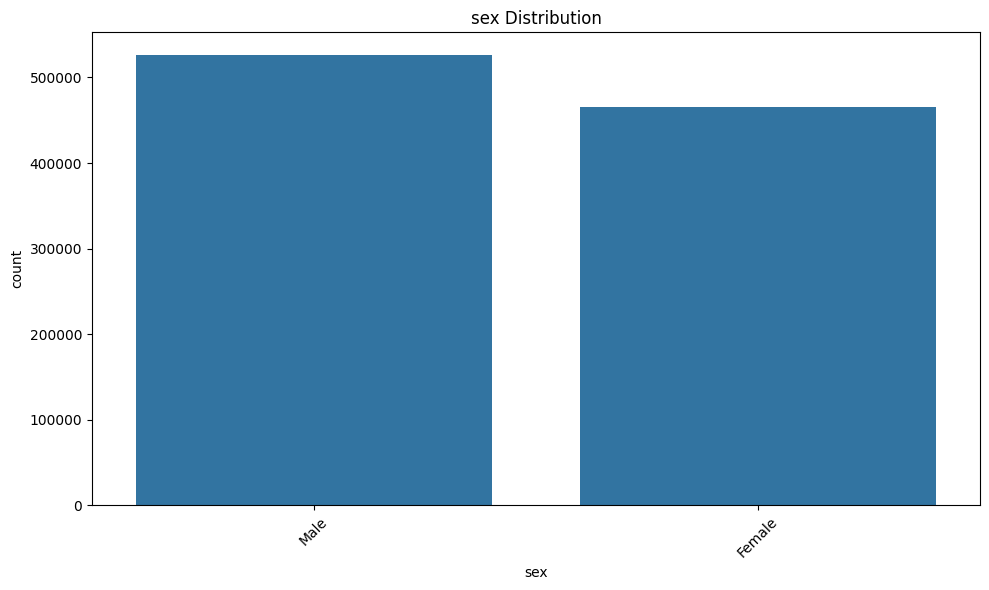


DRK_YN distribution:
DRK_YN
N    495858
Y    495488
Name: count, dtype: int64


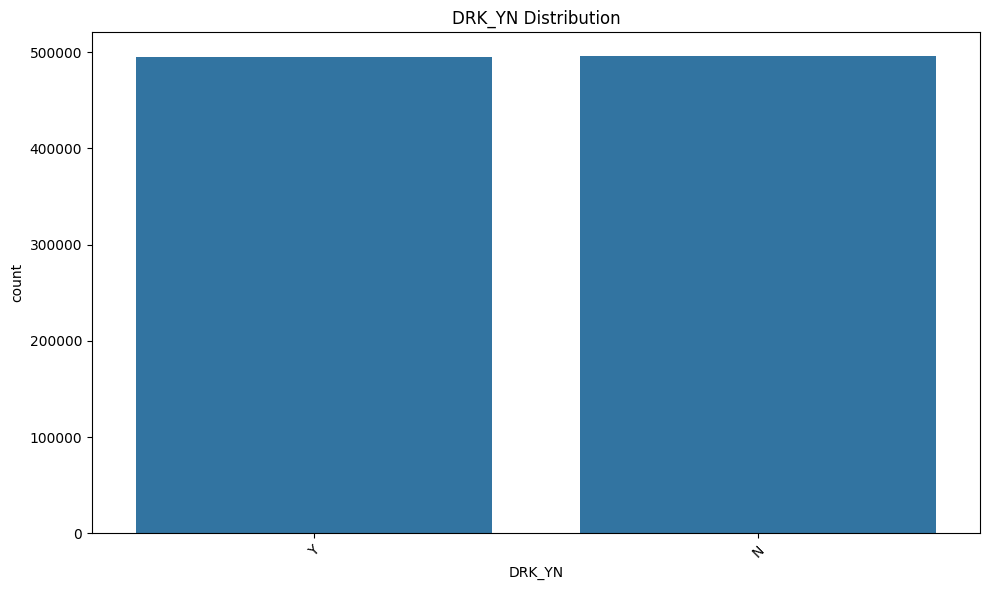

In [50]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
if len(categorical_columns) > 0:
    print("\ncategorical variable analysis:")
    for col in categorical_columns:
        print(f"\n{col} distribution:")
        print(df[col].value_counts())
        
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col)
        plt.title(f'{col} Distribution')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## 3. Data Preprocessing

### Placeholder Value Handling

Certain features in the dataset contain placeholder values representing special conditions or invalid entries. These values were processed as follows:

- **Vision (sight_left, sight_right)**:  
  A value of `9.9` indicates total vision loss (blindness). We replaced these with `0.0` to reflect no measurable vision, preserving the clinical meaning for modeling purposes.

- **Waistline**:  
  A value of `999` is used as a placeholder for invalid or missing waist measurements. These were replaced with `NaN` to be handled later by appropriate imputation strategies.


In [48]:
# Count the number of records where waistline equals the placeholder value 999
num_waistline_999 = (df['waistline'] == 999).sum()
print(f"Number of records with waistline = 999: {num_waistline_999}")

Number of records with waistline = 999: 57


In [49]:
# Replace placeholder values
def replace_placeholders(df):
    df = df.copy()  # Avoid modifying original DataFrame

    # Replace waistline placeholder with NaN
    df['waistline'] = df['waistline'].replace(999, np.nan)

    # Replace 9.9 with 0.0 for blindness in vision fields
    df['sight_left'] = df['sight_left'].replace(9.9, 0.0)
    df['sight_right'] = df['sight_right'].replace(9.9, 0.0)

    return df

In [50]:
df = replace_placeholders(df)
print(df.waistline.isnull().sum())

57


### 3.2 Handling Missing Values: Waistline (Gender-Based Median)
To impute missing `waistline` values (n = 57), we applied median imputation grouped by the `sex` column:

- For each individual with a missing waistline, we used the **median waistline value of their gender group**.
- This method is more precise than global median imputation and avoids overfitting compared to regression imputation on a small sample size.
- A new column `waistline_imputed` was created to track which values were filled.



In [51]:
def impute_waistline_by_sex(df, waistline_col='waistline', sex_col='sex'):
    """
    Impute missing waistline values by sex group median without adding new columns to the DataFrame.

    Parameters:
    - df: pandas DataFrame
    - waistline_col: name of the waistline column
    - sex_col: name of the sex column

    Returns:
    - df_new: DataFrame with imputed waistline, no extra columns
    """
    df_new = df.copy()

    # Create a temporary mask to track missing values
    missing_mask = df_new[waistline_col].isnull()

    # Fill missing waistline values with sex group median
    df_new[waistline_col] = df_new.groupby(sex_col)[waistline_col].transform(
        lambda x: x.fillna(x.median())
    )

    # Temporary create an imputed flag (only for reporting, not saved)
    waistline_imputed = missing_mask

    # Output imputation information
    print(f"Number of values imputed: {waistline_imputed.sum()}")
    print("\nExample of imputed waistline values:")
    print(df_new.loc[waistline_imputed, [sex_col, waistline_col]])

    return df_new


In [52]:
df = impute_waistline_by_sex(df)

Number of values imputed: 57

Example of imputed waistline values:
           sex  waistline
11230   Female       76.0
23779   Female       76.0
30711   Female       76.0
59546   Female       76.0
67877   Female       76.0
91861   Female       76.0
114583  Female       76.0
120470  Female       76.0
125594  Female       76.0
132547  Female       76.0
159083  Female       76.0
161633  Female       76.0
169506  Female       76.0
176101  Female       76.0
185198  Female       76.0
194638  Female       76.0
244064  Female       76.0
252103  Female       76.0
257461  Female       76.0
278576  Female       76.0
279490  Female       76.0
313821  Female       76.0
327805  Female       76.0
392205  Female       76.0
410147  Female       76.0
492587  Female       76.0
514430  Female       76.0
518931  Female       76.0
522039  Female       76.0
530326  Female       76.0
540483  Female       76.0
560275  Female       76.0
564808  Female       76.0
590781  Female       76.0
594169  Female       76

In [53]:
print(df.waistline.isnull().sum())

0


### 3.3 Encoding Categorical Values

In [54]:
def encode_features(df):
    df = df.copy()  # Avoid modifying the original DataFrame

    # Encode target variable
    df['DRK_YN'] = df['DRK_YN'].map({'N': 0, 'Y': 1})
    print("Encoded target variable 'DRK_YN' unique values:", df['DRK_YN'].unique())

    # One-hot encode 'sex' column
    df = pd.get_dummies(df, columns=['sex'], drop_first=True)
    print("\nOne-hot encoded columns related to 'sex':")
    print([col for col in df.columns if 'sex' in col])

    # Display first few rows of encoded features
    print("\nFirst few rows after encoding:")
    print(df[['DRK_YN'] + [col for col in df.columns if 'sex' in col]].head())

    return df


In [55]:
df = encode_features(df)

Encoded target variable 'DRK_YN' unique values: [1 0]

One-hot encoded columns related to 'sex':
['sex_Male']

First few rows after encoding:
   DRK_YN  sex_Male
0       1      True
1       0      True
2       0      True
3       0      True
4       0      True


In [56]:
print(df.head())

   age  height  weight  waistline  sight_left  sight_right  hear_left  \
0   35     170      75       90.0         1.0          1.0        1.0   
1   30     180      80       89.0         0.9          1.2        1.0   
2   40     165      75       91.0         1.2          1.5        1.0   
3   50     175      80       91.0         1.5          1.2        1.0   
4   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP   DBP   BLDS  tot_chole  HDL_chole  LDL_chole  \
0         1.0  120.0  80.0   99.0      193.0       48.0      126.0   
1         1.0  130.0  82.0  106.0      228.0       55.0      148.0   
2         1.0  120.0  70.0   98.0      136.0       41.0       74.0   
3         1.0  145.0  87.0   95.0      201.0       76.0      104.0   
4         1.0  138.0  82.0  101.0      199.0       61.0      117.0   

   triglyceride  hemoglobin  urine_protein  serum_creatinine  SGOT_AST  \
0          92.0        17.1            1.0               1.0      

### 3.4 Feature Engineering

To enhance model performance and interpretability, we apply the following feature engineering strategies:

#### 3.4.1 Create Basic Features

In [57]:
def create_new_features(df):
    df_new = df.copy()

    # Ratio-based features
    df_new['BMI'] = df_new['weight'] / ((df_new['height'] / 100) ** 2)
    df_new['pulse_pressure'] = df_new['SBP'] - df_new['DBP']
    df_new['mean_arterial_pressure'] = df_new['DBP'] + (df_new['pulse_pressure'] / 3)
    df_new['AST_ALT_ratio'] = df_new['SGOT_AST'] / df_new['SGOT_ALT']

    # Average features
    df_new['vision_avg'] = (df_new['sight_left'] + df_new['sight_right']) / 2
    df_new['hearing_avg'] = (df_new['hear_left'] + df_new['hear_right']) / 2

    # Binary indicators
    df_new['vision_loss'] = ((df_new['sight_left'] == 0.0) | (df_new['sight_right'] == 0.0)).astype(int)
    df_new['hearing_loss'] = ((df_new['hear_left'] == 0.0) | (df_new['hear_right'] == 0.0)).astype(int)

    # Optional nonlinear transforms
    df_new['log_gamma_GTP'] = np.log1p(df_new['gamma_GTP'])

    return df_new


In [58]:
df = create_new_features(df)

In [59]:
print(df.head())

   age  height  weight  waistline  sight_left  sight_right  hear_left  \
0   35     170      75       90.0         1.0          1.0        1.0   
1   30     180      80       89.0         0.9          1.2        1.0   
2   40     165      75       91.0         1.2          1.5        1.0   
3   50     175      80       91.0         1.5          1.2        1.0   
4   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP   DBP   BLDS  tot_chole  HDL_chole  LDL_chole  \
0         1.0  120.0  80.0   99.0      193.0       48.0      126.0   
1         1.0  130.0  82.0  106.0      228.0       55.0      148.0   
2         1.0  120.0  70.0   98.0      136.0       41.0       74.0   
3         1.0  145.0  87.0   95.0      201.0       76.0      104.0   
4         1.0  138.0  82.0  101.0      199.0       61.0      117.0   

   triglyceride  hemoglobin  urine_protein  serum_creatinine  SGOT_AST  \
0          92.0        17.1            1.0               1.0      

### 3.5 Scaling and Normalization

- **Logistic Regression**:
  - Sensitive to feature scales and multicollinearity
  - All numeric features were standardized (mean = 0, std = 1)

- **Random Forest & XGBoost**:
  - Tree-based models do not require feature scaling
  - Original feature values are retained

To accommodate this, we created separate datasets:
- `df_for_logistic`: for Logistic Regression
- `df_for_rf`: for Random Forest
- `df_for_xgb`: for XGBoost


In [60]:
def prepare_for_logistic_regression(df, target_col='DRK_YN'):
    df_lr = df.copy()

    # Separate features and target
    features = df_lr.drop(columns=[target_col])
    target = df_lr[target_col]

    # Select numeric columns to scale
    numeric_cols = features.select_dtypes(include=['float64', 'int64']).columns

    # Standardize only feature columns
    scaler = StandardScaler()
    features[numeric_cols] = scaler.fit_transform(features[numeric_cols])

    # Recombine features and unscaled target
    df_scaled = pd.concat([features, target], axis=1)

    return df_scaled

def prepare_for_tree_models(df):
    """
    Prepare dataset for tree-based models (Random Forest, XGBoost):
    - No scaling needed
    - Return a copy of the original DataFrame
    """
    return df.copy()


In [61]:
# create baseline DataFrame (already preprocessed and feature-engineered)
df_base = df.copy()

# create separate versions for each model type
df_for_logistic = prepare_for_logistic_regression(df_base)
df_for_rf = prepare_for_tree_models(df_base)
df_for_xgb = prepare_for_tree_models(df_base)
df_for_lgb = prepare_for_tree_models(df_base)

In [62]:
print(df_for_logistic.head())

        age    height    weight  waistline  sight_left  sight_right  \
0 -0.889514  0.835874  0.936210   0.919525    0.145808     0.153230   
1 -1.242090  1.913117  1.335755   0.815267   -0.144050     0.735427   
2 -0.536938  0.297252  0.936210   1.023782    0.725524     1.608722   
3  0.168215  1.374495  1.335755   1.023782    1.595097     0.735427   
4  0.168215  0.297252 -0.262425  -0.123054    0.145808     0.735427   

   hear_left  hear_right       SBP       DBP      BLDS  tot_chole  HDL_chole  \
0  -0.180329   -0.177296 -0.167261  0.399153 -0.058910  -0.066141  -0.518422   
1  -0.180329   -0.177296  0.520349  0.601391  0.230586   0.839184  -0.112353   
2  -0.180329   -0.177296 -0.167261 -0.612034 -0.100267  -1.540528  -0.924490   
3  -0.180329   -0.177296  1.551763  1.106985 -0.224337   0.140790   1.105852   
4  -0.180329   -0.177296  1.070436  0.601391  0.023803   0.089058   0.235705   

   LDL_chole  triglyceride  hemoglobin  urine_protein  serum_creatinine  \
0   0.361643     

In [63]:
print(df_for_rf.head())

   age  height  weight  waistline  sight_left  sight_right  hear_left  \
0   35     170      75       90.0         1.0          1.0        1.0   
1   30     180      80       89.0         0.9          1.2        1.0   
2   40     165      75       91.0         1.2          1.5        1.0   
3   50     175      80       91.0         1.5          1.2        1.0   
4   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP   DBP   BLDS  tot_chole  HDL_chole  LDL_chole  \
0         1.0  120.0  80.0   99.0      193.0       48.0      126.0   
1         1.0  130.0  82.0  106.0      228.0       55.0      148.0   
2         1.0  120.0  70.0   98.0      136.0       41.0       74.0   
3         1.0  145.0  87.0   95.0      201.0       76.0      104.0   
4         1.0  138.0  82.0  101.0      199.0       61.0      117.0   

   triglyceride  hemoglobin  urine_protein  serum_creatinine  SGOT_AST  \
0          92.0        17.1            1.0               1.0      

### 3.6 Multicollinearity Detection and Feature Selection for Logistic Regression

Since logistic regression is sensitive to multicollinearity, we applied Variance Inflation Factor (VIF) analysis:

- Features with **VIF > 5** were iteratively removed
- This reduces instability in coefficient estimation
- The resulting feature set is more robust and interpretable

We used the `statsmodels` package to calculate VIF for each numeric feature.



correlation analysis:


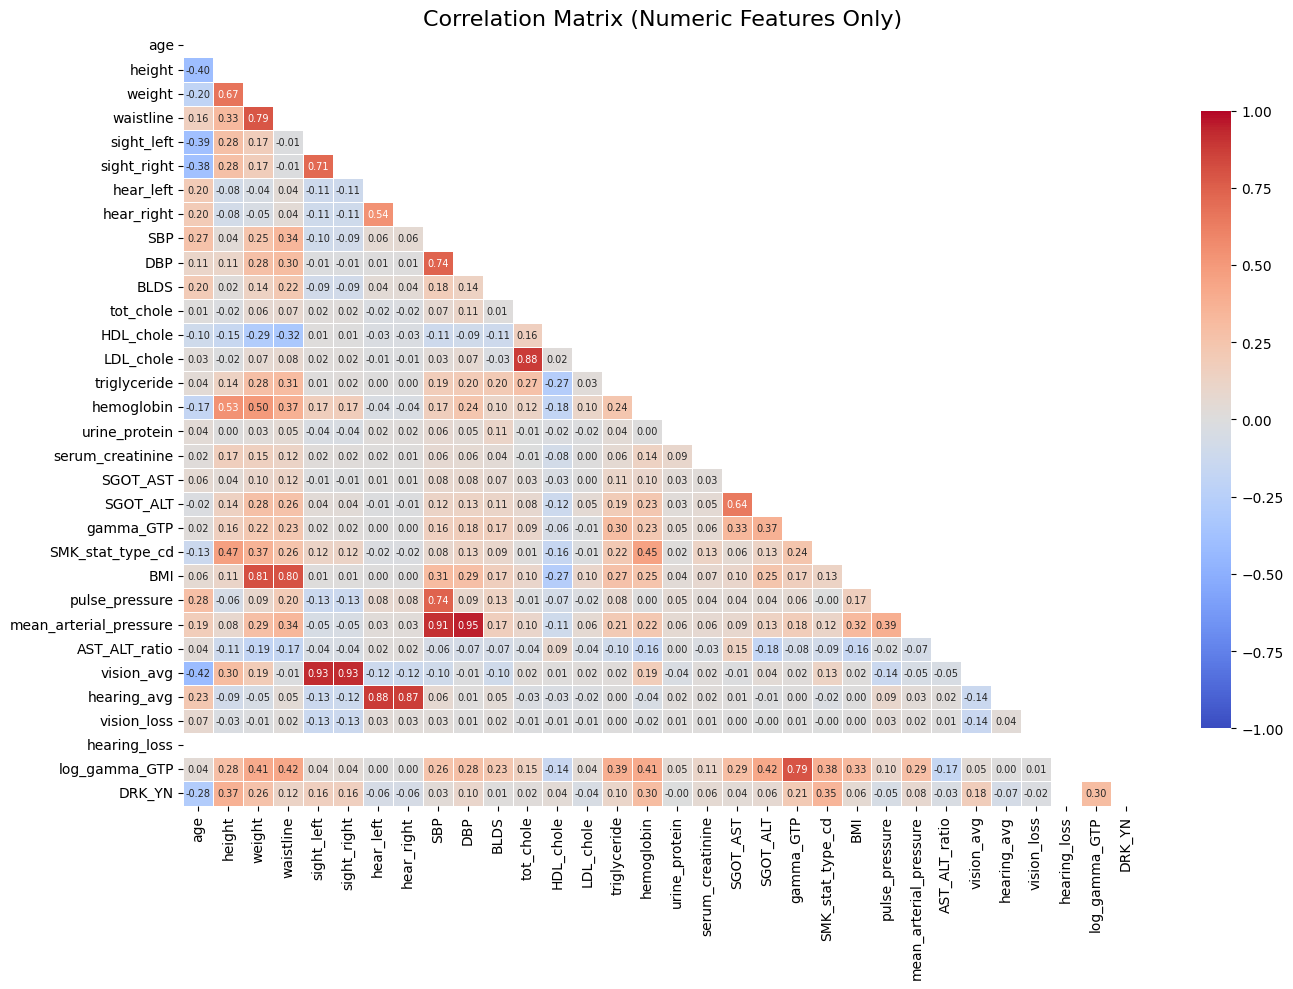

In [79]:
print("\ncorrelation analysis:")
plot_correlation_matrix(df_for_logistic)

In [82]:
def select_low_vif_features(df, threshold=5.0):
    """
    Removes features with high VIF to reduce multicollinearity.

    Parameters:
        df: DataFrame with numeric features only (already scaled)
        threshold: VIF value above which a feature will be dropped

    Returns:
        A new DataFrame with low-VIF features only
    """
    df_vif = df.copy()

    # Step 1: Ensure only numeric and non-NaN columns are passed
    df_vif = df_vif.select_dtypes(include=['float64', 'int64'])  # remove non-numeric
    df_vif = df_vif.replace([np.inf, -np.inf], np.nan).dropna()  # remove inf and nan

    dropped = True
    while dropped:
        dropped = False
        vif = pd.DataFrame()
        vif["feature"] = df_vif.columns
        vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

        max_vif = vif["VIF"].max()
        if max_vif > threshold:
            drop_feature = vif.sort_values("VIF", ascending=False)["feature"].iloc[0]
            print(f"Dropping '{drop_feature}' with VIF = {max_vif:.2f}")
            df_vif = df_vif.drop(columns=[drop_feature])
            dropped = True

    print("\nFinal selected features (low multicollinearity):")
    print(df_vif.columns.tolist())
    return df_vif



In [83]:
df_logistic_vif_selected = select_low_vif_features(df_for_logistic)

/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Dropping 'hear_right' with VIF = 23139749.79


/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Dropping 'DBP' with VIF = 9260867.40


/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Dropping 'mean_arterial_pressure' with VIF = 105579087.90


/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Dropping 'vision_avg' with VIF = inf


/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Dropping 'weight' with VIF = 133.83


/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Dropping 'tot_chole' with VIF = 8.34


/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



Final selected features (low multicollinearity):
['age', 'height', 'waistline', 'sight_left', 'sight_right', 'hear_left', 'SBP', 'BLDS', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'SMK_stat_type_cd', 'BMI', 'pulse_pressure', 'AST_ALT_ratio', 'hearing_avg', 'vision_loss', 'hearing_loss', 'log_gamma_GTP', 'DRK_YN']


In [84]:
print(df_logistic_vif_selected.head())

        age    height  waistline  sight_left  sight_right  hear_left  \
0 -0.889514  0.835874   0.919525    0.145808     0.153230  -0.180329   
1 -1.242090  1.913117   0.815267   -0.144050     0.735427  -0.180329   
2 -0.536938  0.297252   1.023782    0.725524     1.608722  -0.180329   
3  0.168215  1.374495   1.023782    1.595097     0.735427  -0.180329   
4  0.168215  0.297252  -0.123054    0.145808     0.735427  -0.180329   

        SBP      BLDS  HDL_chole  LDL_chole  triglyceride  hemoglobin  \
0 -0.167261 -0.058910  -0.518422   0.361643     -0.392788    1.810919   
1  0.520349  0.230586  -0.112353   0.975435     -0.109022    0.990693   
2 -0.167261 -0.100267  -0.924490  -1.089136     -0.275368    0.990693   
3  1.551763 -0.224337   1.105852  -0.252148     -0.255798    2.126391   
4  1.070436  0.023803   0.235705   0.110547     -0.275368   -0.271194   

   urine_protein  serum_creatinine  SGOT_AST  SGOT_ALT  gamma_GTP  \
0       -0.21526          0.290374 -0.212371  0.351404   0.

### 3.7 Outlier Treatment

### 3.7 Data Splitting(Train/Validation/Test)


In [85]:
def split_dataset(df, target_col='DRK_YN', train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    assert train_size + val_size + test_size == 1.0, "Train, val, and test sizes must sum to 1.0"

    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Step 1: train vs temp (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(val_size + test_size), stratify=y, random_state=random_state
    )

    # Step 2: validation vs test
    relative_val_size = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1 - relative_val_size), stratify=y_temp, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


In [86]:
# For logistic regression
X_train_lr, X_val_lr, X_test_lr, y_train_lr, y_val_lr, y_test_lr = split_dataset(df_logistic_vif_selected)

# For Random Forest
X_train_rf, X_val_rf, X_test_rf, y_train_rf, y_val_rf, y_test_rf = split_dataset(df_for_rf)

# For XGBoost
X_train_xgb, X_val_xgb, X_test_xgb, y_train_xgb, y_val_xgb, y_test_xgb = split_dataset(df_for_xgb)

# For LightGBM
X_train_lgb, X_val_lgb, X_test_lgb, y_train_lgb, y_val_lgb, y_test_lgb = split_dataset(df_for_lgb)


## 4. Modeling

### 4.1 Baseline Model: Logistic Regression

To balance model interpretability and multicollinearity control, we implemented a hybrid feature selection approach:

- **Manual selection**: Based on domain knowledge (keep/drop specific features)
- **VIF-based filtering**: Automatically remove features with VIF > 5


In [87]:
def train_logistic_regression(X_train, y_train, X_val, y_val, X_test, y_test):
    model = LogisticRegression(max_iter=1000, solver='liblinear')
    model.fit(X_train, y_train)

    def evaluate(name, X_eval, y_eval):
        y_pred = model.predict(X_eval)
        acc = accuracy_score(y_eval, y_pred)
        print(f"\n[{name} Accuracy] {acc:.4f}")
        print("Confusion Matrix:\n", confusion_matrix(y_eval, y_pred))
        print("Classification Report:\n", classification_report(y_eval, y_pred))

    print("\n--- Evaluating Logistic Regression ---")
    evaluate("Validation", X_val, y_val)
    evaluate("Test", X_test, y_test)

    return model, X_train.columns.tolist()

In [88]:
# Automatically remove features with VIF > 5
logistic_model = train_logistic_regression(X_train_lr, y_train_lr, X_val_lr, y_val_lr, X_test_lr, y_test_lr)


--- Evaluating Logistic Regression ---

[Validation Accuracy] 0.7275
Confusion Matrix:
 [[54853 19526]
 [20997 53326]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73     74379
           1       0.73      0.72      0.72     74323

    accuracy                           0.73    148702
   macro avg       0.73      0.73      0.73    148702
weighted avg       0.73      0.73      0.73    148702


[Test Accuracy] 0.7284
Confusion Matrix:
 [[55141 19238]
 [21155 53168]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73     74379
           1       0.73      0.72      0.72     74323

    accuracy                           0.73    148702
   macro avg       0.73      0.73      0.73    148702
weighted avg       0.73      0.73      0.73    148702



#### 4.1.1 Visualization: Coefficient Bar Plot


In [89]:
def plot_logistic_coefficients(model, feature_names, top_n=None):
    coefs = model.coef_[0]
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs,
        'Abs_Coefficient': np.abs(coefs),
        'Direction': ['Positive' if c > 0 else 'Negative' for c in coefs]
    })

    if top_n:
        coef_df = coef_df.nlargest(top_n, 'Abs_Coefficient')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=coef_df.sort_values('Coefficient'),
                x='Coefficient', y='Feature',
                hue='Direction', dodge=False, palette={'Positive': 'green', 'Negative': 'red'})

    plt.axvline(0, color='black', linestyle='--')
    plt.title('Logistic Regression Coefficients')
    plt.tight_layout()
    plt.show()



--- Evaluating Logistic Regression ---

[Validation Accuracy] 0.7275
Confusion Matrix:
 [[54853 19526]
 [20997 53326]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73     74379
           1       0.73      0.72      0.72     74323

    accuracy                           0.73    148702
   macro avg       0.73      0.73      0.73    148702
weighted avg       0.73      0.73      0.73    148702


[Test Accuracy] 0.7284
Confusion Matrix:
 [[55141 19238]
 [21155 53168]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73     74379
           1       0.73      0.72      0.72     74323

    accuracy                           0.73    148702
   macro avg       0.73      0.73      0.73    148702
weighted avg       0.73      0.73      0.73    148702



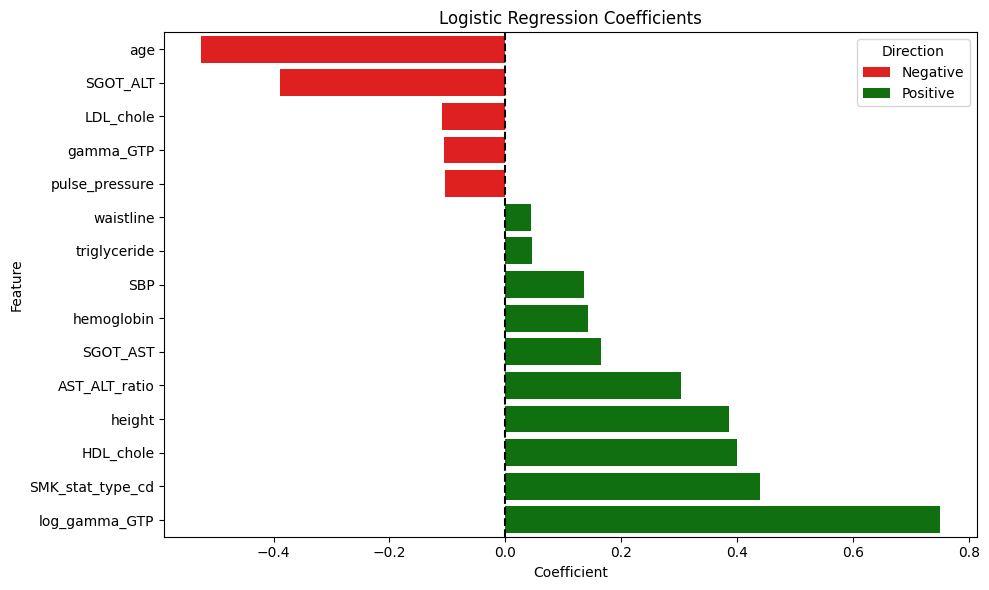

In [90]:
model, selected_features = train_logistic_regression(X_train_lr, y_train_lr, X_val_lr, y_val_lr, X_test_lr, y_test_lr)
# Visualize model coefficients
plot_logistic_coefficients(model, feature_names=selected_features, top_n=15)

#### 4.1.2 Visualization: Confusion Matrix Heatmap

In [1]:
def plot_confusion_matrix(y_true, y_pred, labels=[0, 1]):
    """
    Plot a confusion matrix heatmap.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()


--- Evaluating Logistic Regression ---

[Validation Accuracy] 0.7275
Confusion Matrix:
 [[54853 19526]
 [20997 53326]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73     74379
           1       0.73      0.72      0.72     74323

    accuracy                           0.73    148702
   macro avg       0.73      0.73      0.73    148702
weighted avg       0.73      0.73      0.73    148702


[Test Accuracy] 0.7284
Confusion Matrix:
 [[55141 19238]
 [21155 53168]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73     74379
           1       0.73      0.72      0.72     74323

    accuracy                           0.73    148702
   macro avg       0.73      0.73      0.73    148702
weighted avg       0.73      0.73      0.73    148702



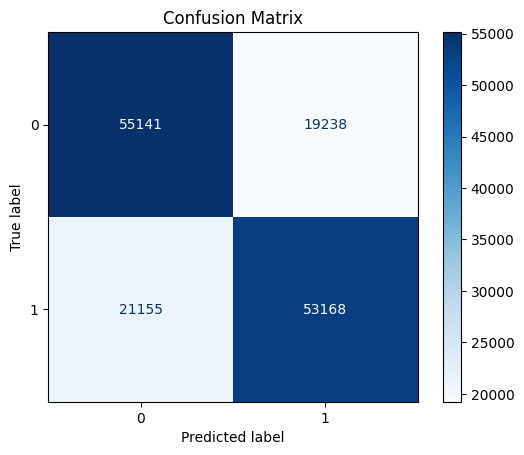

In [92]:
model, selected_features = train_logistic_regression(X_train_lr, y_train_lr, X_val_lr, y_val_lr, X_test_lr, y_test_lr)
# Outcome
y_pred_test = model.predict(X_test_lr)

# Plot confusion matrix
plot_confusion_matrix(y_test_lr, y_pred_test)

#### 4.1.3 Visualization: ROC Curve with AUC Score

In [93]:
def plot_roc_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


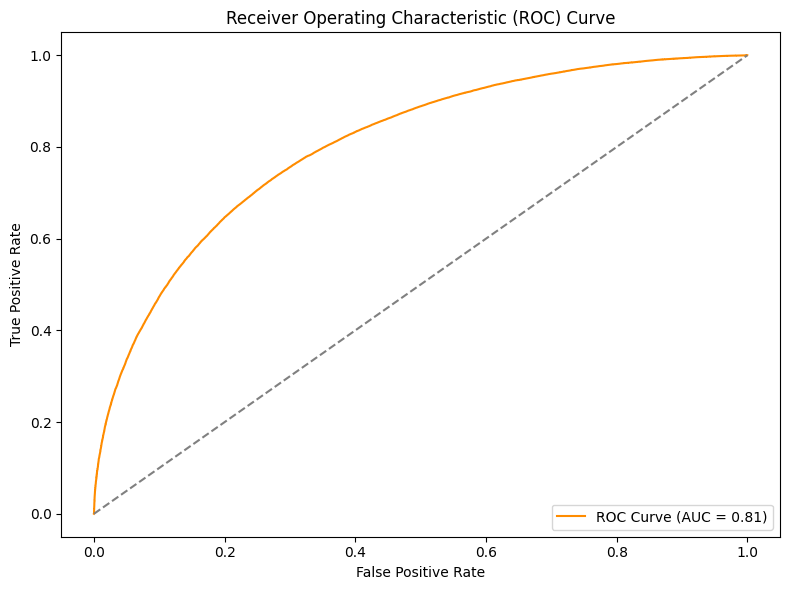

In [94]:
# Plot ROC curve
plot_roc_curve(model, X_test_lr, y_test_lr)


### 4.2 Tree-based Models Random Forest

#### 4.2.1 Random Forest

In [95]:
def train_random_forest(X_train, y_train, X_val, y_val, X_test, y_test):
    # Initialize and train
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluation function
    def evaluate(name, X, y):
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f"\n[{name} Accuracy] {acc:.4f}")
        print(f"{name} Confusion Matrix:\n", confusion_matrix(y, y_pred))
        print(f"{name} Classification Report:\n", classification_report(y, y_pred))
        return y_pred

    # Evaluate on validation and test sets
    y_val_pred = evaluate("Validation", X_val, y_val)
    y_test_pred = evaluate("Test", X_test, y_test)

    return model, y_test_pred

In [96]:
# Training random forest model
rf_model, y_pred_rf = train_random_forest(
    X_train_rf, y_train_rf, X_val_rf, y_val_rf, X_test_rf, y_test_rf
)


[Validation Accuracy] 0.7344
Validation Confusion Matrix:
 [[54887 19492]
 [19999 54324]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.74      0.74     74379
           1       0.74      0.73      0.73     74323

    accuracy                           0.73    148702
   macro avg       0.73      0.73      0.73    148702
weighted avg       0.73      0.73      0.73    148702


[Test Accuracy] 0.7352
Test Confusion Matrix:
 [[55118 19261]
 [20110 54213]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.74      0.74     74379
           1       0.74      0.73      0.73     74323

    accuracy                           0.74    148702
   macro avg       0.74      0.74      0.74    148702
weighted avg       0.74      0.74      0.74    148702



##### 4.2.1.1 Visualization: Feature Importances

In [97]:
def plot_rf_feature_importance(model, feature_names, top_n=15):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    if top_n:
        importance_df = importance_df.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
    plt.title("Random Forest Feature Importances")
    plt.tight_layout()
    plt.show()

/var/folders/fh/_tq_jbr50895yx1hkbgpct5m0000gn/T/ipykernel_84101/3677871197.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


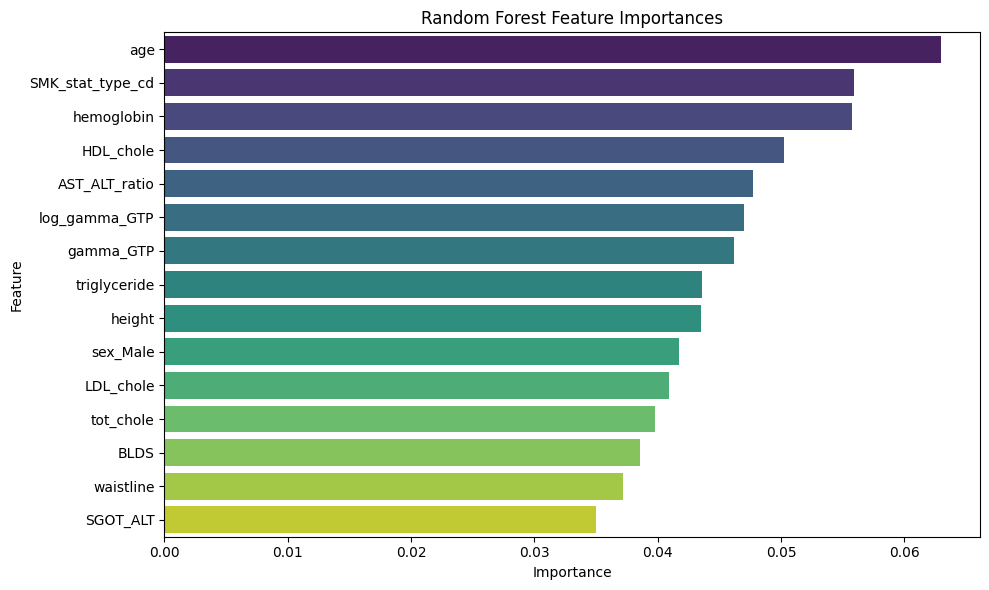

In [98]:
# Plot feature importances
plot_rf_feature_importance(rf_model, feature_names=X_train_rf.columns.tolist(), top_n=15)

##### 4.2.1.2 Visualization: Confusion Matrix

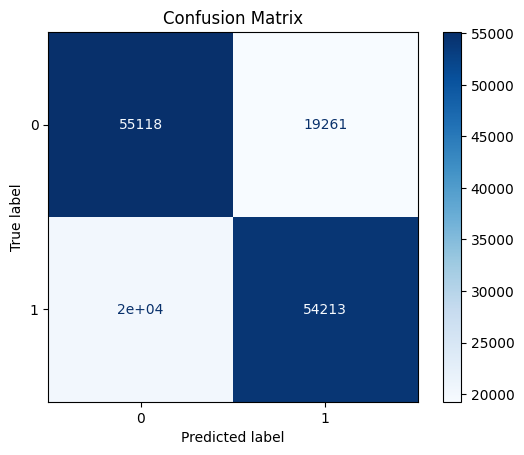

In [99]:
# Plot confusion matrix on test set
plot_confusion_matrix(y_test_rf, y_pred_rf)

##### 4.2.1.3 Visualization: ROC Curve

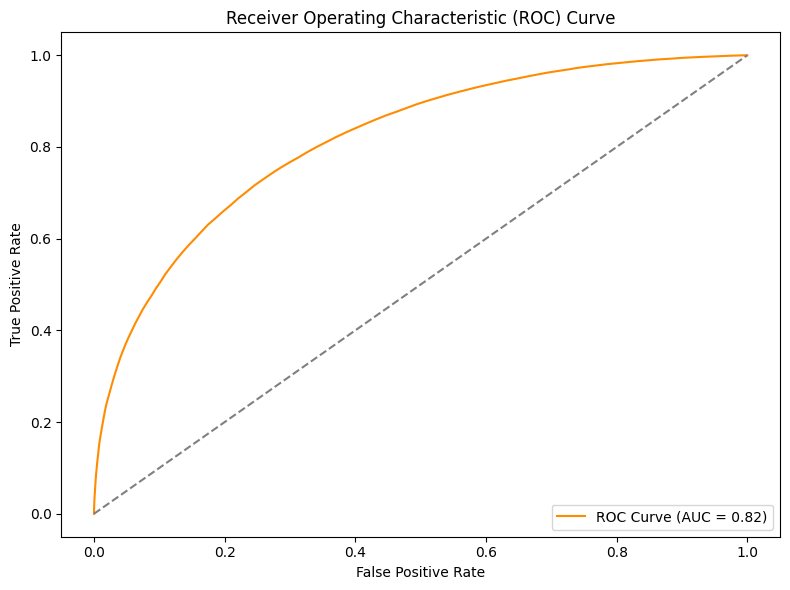

In [100]:
# Plot ROC curve
plot_roc_curve(rf_model, X_test_rf, y_test_rf)

#### 4.2.2 XGBoost

In [101]:
def train_xgboost(X_train, y_train, X_val, y_val, X_test, y_test):
    # Initialize and train the model
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)

    # Evaluation function
    def evaluate(name, X, y):
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f"\n[{name} Accuracy] {acc:.4f}")
        print(f"{name} Confusion Matrix:\n", confusion_matrix(y, y_pred))
        print(f"{name} Classification Report:\n", classification_report(y, y_pred))
        return y_pred

    # Evaluate on validation and test sets
    y_val_pred = evaluate("Validation", X_val, y_val)
    y_test_pred = evaluate("Test", X_test, y_test)

    return model, y_test_pred

In [102]:
# Train the XGBoost model
xgb_model, y_pred_xgb = train_xgboost(
    X_train_xgb, y_train_xgb, X_val_xgb, y_val_xgb, X_test_xgb, y_test_xgb
)

/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:50:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[Validation Accuracy] 0.7387
Validation Confusion Matrix:
 [[54664 19715]
 [19135 55188]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74     74379
           1       0.74      0.74      0.74     74323

    accuracy                           0.74    148702
   macro avg       0.74      0.74      0.74    148702
weighted avg       0.74      0.74      0.74    148702


[Test Accuracy] 0.7400
Test Confusion Matrix:
 [[55000 19379]
 [19278 55045]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74     74379
           1       0.74      0.74      0.74     74323

    accuracy                           0.74    148702
   macro avg       0.74      0.74      0.74    148702
weighted avg       0.74      0.74      0.74    148702



##### 4.2.2.1 Visualization: Feature Importances

In [103]:
def plot_xgb_feature_importance(model, feature_names, top_n=15):
    importance_dict = model.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'Feature': list(importance_dict.keys()),
        'Importance': list(importance_dict.values())
    })

    # Sort and match names (some XGBoost keys may be like f0, f1, ... unless feature_names are passed correctly)
    if all(f.startswith('f') for f in importance_df['Feature']):
        importance_df['Feature'] = [feature_names[int(f[1:])] for f in importance_df['Feature']]

    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette='magma')
    plt.title("XGBoost Feature Importances (Gain)")
    plt.tight_layout()
    plt.show()

/var/folders/fh/_tq_jbr50895yx1hkbgpct5m0000gn/T/ipykernel_84101/2033818380.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='magma')


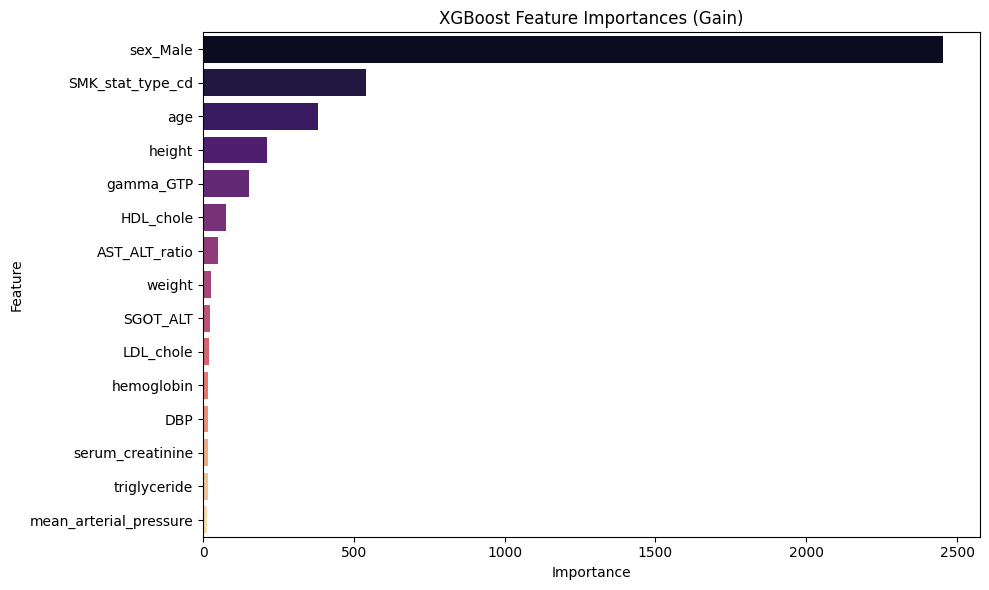

In [104]:
# Plot feature importances
plot_xgb_feature_importance(xgb_model, feature_names=X_train_xgb.columns.tolist(), top_n=15)

##### 4.2.2.2 Visualization: Confusion Matrix

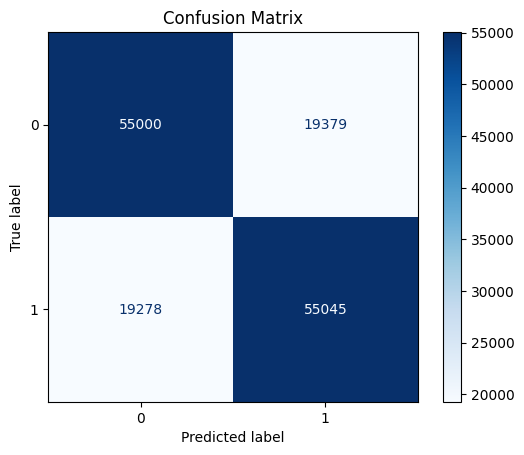

In [105]:
# Plot confusion matrix
plot_confusion_matrix(y_test_xgb, y_pred_xgb)

##### 4.2.2.3 Visualization: ROC Curve

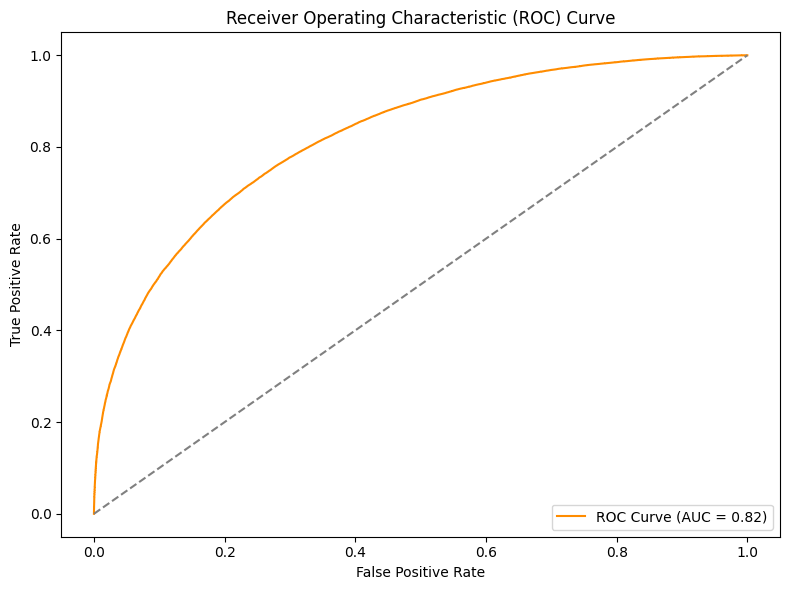

In [106]:
# Plot ROC curve
plot_roc_curve(xgb_model, X_test_xgb, y_test_xgb)

#### 4.2.3 LightGBM

In [107]:
def train_lightgbm(X_train, y_train, X_val, y_val, X_test, y_test):
    # Initialize and train
    model = lgb.LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Evaluation function
    def evaluate(name, X, y):
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        print(f"\n[{name} Accuracy] {acc:.4f}")
        print(f"{name} Confusion Matrix:\n", confusion_matrix(y, y_pred))
        print(f"{name} Classification Report:\n", classification_report(y, y_pred))
        return y_pred

    # Evaluate on validation and test sets
    y_val_pred = evaluate("Validation", X_val, y_val)
    y_test_pred = evaluate("Test", X_test, y_test)

    return model, y_test_pred

In [108]:
# Train the LightGBM model
lgb_model, y_pred_lgb = train_lightgbm(
    X_train_lgb, y_train_lgb, X_val_lgb, y_val_lgb, X_test_lgb, y_test_lgb
)

[LightGBM] [Info] Number of positive: 346842, number of negative: 347100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3815
[LightGBM] [Info] Number of data points in the train set: 693942, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499814 -> initscore=-0.000744
[LightGBM] [Info] Start training from score -0.000744

[Validation Accuracy] 0.7395
Validation Confusion Matrix:
 [[54463 19916]
 [18817 55506]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74     74379
           1       0.74      0.75      0.74     74323

    accuracy                           0.74    148702
   macro avg       0.74      0.74      0.74    148702
weighted avg       0.74      0.74      0.

##### 4.2.3.1 Visualization: Feature Importances

/var/folders/fh/_tq_jbr50895yx1hkbgpct5m0000gn/T/ipykernel_84101/3677871197.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


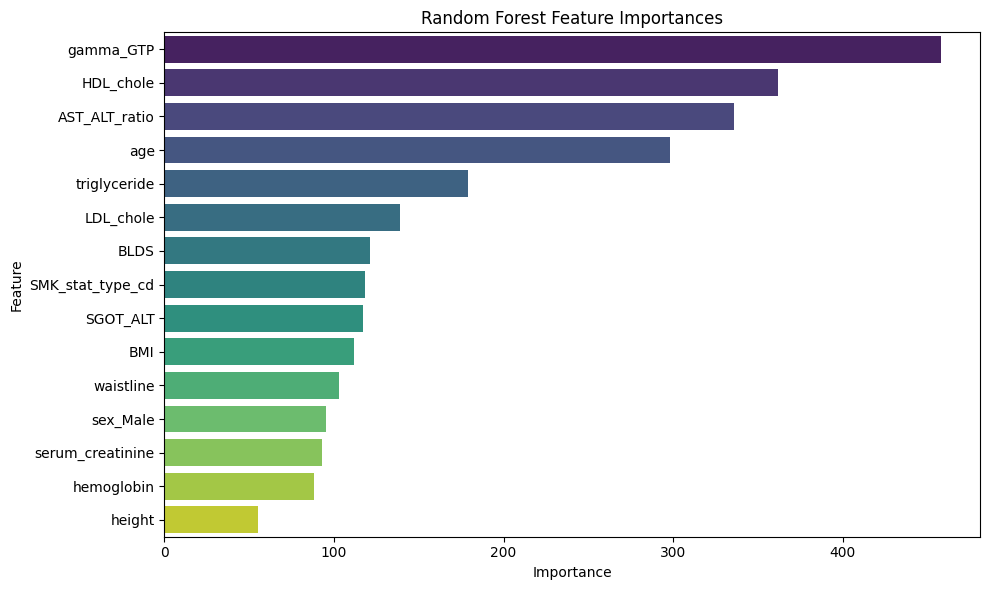

In [110]:
# Plot feature importances
plot_rf_feature_importance(lgb_model, feature_names=X_train_lgb.columns.tolist(), top_n=15)

##### 4.2.3.2 Visualization: Confusion Matrix


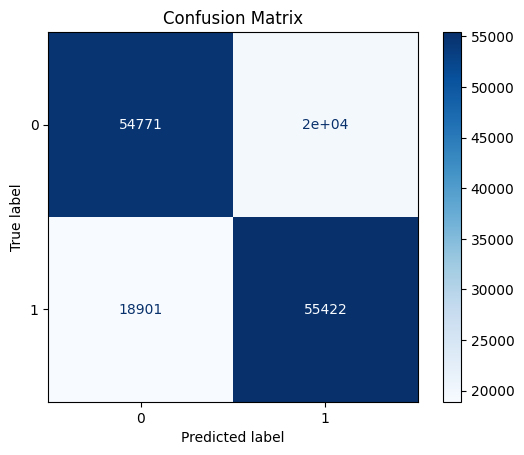

In [111]:
# Plot confusion matrix
plot_confusion_matrix(y_test_lgb, y_pred_lgb)

##### 4.2.3.3 Visualization: ROC Curve

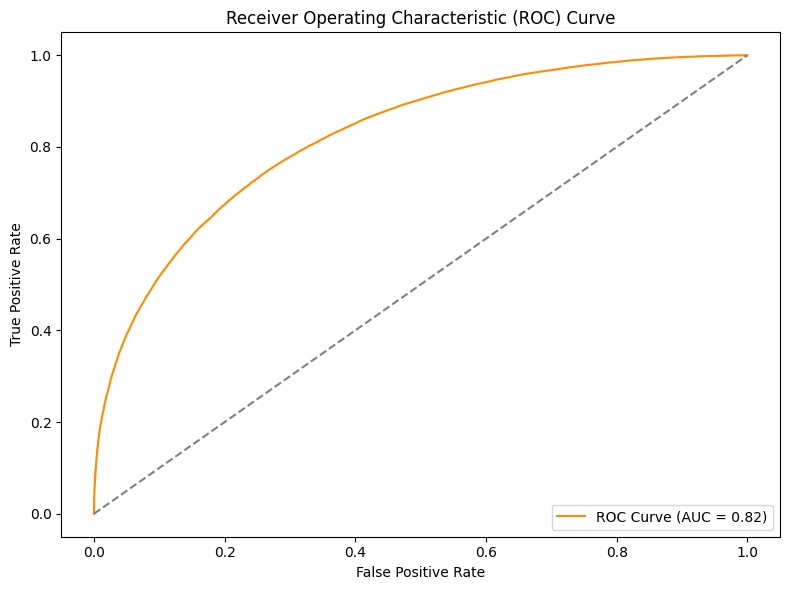

In [112]:
# Plot ROC curve
plot_roc_curve(lgb_model, X_test_lgb, y_test_lgb)

### 4.3 Neural Network Model

## 5. Evaluation Metrics

### 5.1 Model Interpretability with SHAP
- SHAP Sparsity: top-k feature dominance
- SHAP Stability: neighbor-wise consistency
- Identify top predictors like γ-GTP and BMI